In [45]:
!pip install category_encoders
!pip install xgboost

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import libraries

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.james_stein import JamesSteinEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import  make_scorer
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from typing import Tuple,List
from sklearn.base import BaseEstimator, TransformerMixin

## Data Integration

### Read data from file csv

In [48]:
bonbanh = pd.read_csv('/content/drive/MyDrive/Dataset for ML/BonBanh (1).csv')
bonbanh.head()

,Tên xe,Năm sản xuất,Tình trạng,Số km đã đi,Xuất xứ,Kiểu dáng,Hộp số,Động cơ,Màu ngoại thất,Màu nội thất,Dẫn động,Số chỗ,Giá xe
0,Xe Peugeot 2008 Active 1.2 AT,2022,Xe đã dùng,"30,000 Km",Lắp ráp trong nước,Crossover,Số tự động,Xăng 1.2 L,Đỏ,Đen,FWD - Dẫn động cầu trước,5 chỗ,679 Triệu
1,Xe Mercedes Benz C class C300 AMG,2014,Xe đã dùng,"90,000 Km",Lắp ráp trong nước,Sedan,Số tự động,Xăng 3.0 L,Trắng,Đen,RFD - Dẫn động cầu sau,5 chỗ,499 Triệu
2,Xe Mercedes Benz E class E200 Exclusive,2022,Xe đã dùng,500 Km,Lắp ráp trong nước,Sedan,Số tự động,Xăng 2.0 L,Đen,Nâu,RFD - Dẫn động cầu sau,5 chỗ,2 Tỷ 229 Triệu
3,Xe Mercedes Benz C class C200 Avantgarde,2021,Xe đã dùng,80 Km,Lắp ráp trong nước,Sedan,Số tự động,Xăng 1.5 L,Xanh,Nâu,RFD - Dẫn động cầu sau,5 chỗ,1 Tỷ 399 Triệu
4,Xe Mercedes Benz E class E200 Exclusive,2022,Xe đã dùng,"8,888 Km",Lắp ráp trong nước,Sedan,Số tự động,Xăng 2.0 L,Trắng,Nâu,RFD - Dẫn động cầu sau,5 chỗ,1 Tỷ 788 Triệu


In [49]:
chotot = pd.read_csv('/content/drive/MyDrive/Dataset for ML/chotot (2).csv')
chotot.head()

,Tiêu đề,Hãng,Dòng xe,Năm sản xuất,Số km đã đi,Tình trạng,Hộp số,Nhiên liệu,Xuất xứ,Kiểu dáng,Số chỗ,Giá xe
0,bán xe Xpander chính chủ,Mitsubishi,Xpander,2019,50000.0,Đã sử dụng,Tự động,Xăng,Nước khác,NaN,NaN,460.000.000 đ
1,Lên đời bán xe Pajero Sport mua hãng còn mới,Mitsubishi,Pajero Sport,2021,60000.0,Đã sử dụng,Tự động,Dầu,Thái Lan,NaN,NaN,830.000.000 đ
2,"Ford Everest Wildtrak, Đủ màu giao ngay",Ford,Everest,2023,NaN,Mới,Bán tự động,Dầu,Thái Lan,SUV / Cross over,NaN,1.409.000.000 đ
3,Everest 4x4 2023 giảm giá tới 120tr góp từ 250tr,Ford,Everest,2023,NaN,Mới,Tự động,Dầu,Thái Lan,SUV / Cross over,NaN,1.352.000.000 đ
4,cần bán xe lux A 2.0 đời 2019 Bản prelium mới đét,Vinfast,Lux A2.0,2019,26000.0,Đã sử dụng,Tự động,Xăng,Việt Nam,NaN,NaN,605.000.000 đ


### Change value '-' into null

In [50]:
for col in bonbanh:
    bonbanh[col] = bonbanh[col].replace('-', np.nan)

### Remove all price-missing or brand-missing car

In [51]:
bonbanh = bonbanh.dropna(subset=['Giá xe'])
chotot = chotot.dropna(subset=['Giá xe'])
chotot = chotot.dropna(subset=['Hãng'])

### Change value in each field with same format in 2 datasets

#### Convert **Number of kms traveled** to int and change it to *0* for all new cars

In [52]:
bonbanh['Số km đã đi'] = bonbanh['Số km đã đi'].replace('Xe mới', '0 Km')
bonbanh['Số km đã đi'] = bonbanh['Số km đã đi'].str.replace('Km', '')
def change_to_int(so_km):
    km = 0
    so_km = [int(x) for x in so_km.split(',')]
    n = len(so_km)
    for i in range(n):
        km += 1000**(n-i-1)*so_km[i]
    return km
bonbanh['Số km đã đi'] = bonbanh['Số km đã đi'].apply(change_to_int)

In [53]:
chotot.loc[chotot['Tình trạng'] == 'Mới', 'Số km đã đi'] = 0

#### Convert **Price** into *Million* unit

In [54]:
def convert_price(price):
    price = price.split(" ")
    if len(price) == 4:
        return int(price[0])*1000 + int(price[2])
    else:
        if price[-1] == 'Tỷ':
            return int(price[0]) * 1000
        else:
            return int(price[0])
bonbanh['Giá xe'] = bonbanh['Giá xe'].apply(convert_price)
bonbanh['Giá xe'] = bonbanh['Giá xe'].astype('int64')

In [55]:
chotot['Giá xe'] = chotot['Giá xe'].astype(str).str.rstrip('đ')
def price_convert(x):
    l = x.split('.')
    n = ''.join(l[0:len(x)-2:1])
    return n[0:-7]
chotot['Giá xe'] = chotot['Giá xe'].apply(price_convert)
chotot['Giá xe'] = chotot['Giá xe'].astype('int64')

#### Change **State**

In [56]:
chotot['Tình trạng'] = chotot['Tình trạng'].replace('Đã sử dụng', 'Xe đã dùng')
chotot['Tình trạng'] = chotot['Tình trạng'].replace('Mới', 'Xe mới')

#### Change **Gearbox**

In [57]:
def change_gearbox(x):
    if x == 'Tự động' or x == '4':
        return 'Số tự động'
    elif x == 'Bán tự động':
        return 'Số hỗn hợp'
    elif x == 'Số sàn' or x == '5':
        return 'Số tay'
    else:
        return x
chotot['Hộp số'] = chotot['Hộp số'].apply(change_gearbox)

#### Change **Design**

In [58]:
def change_design(x):
    if x == 'Bán tải / Pickup' or x == 'Pick-up (bán tải)':
        return 'Pickup'
    elif x == 'SUV' or x == 'Crossover' or x == 'SUV / Cross over':
        return 'SUV/Crossover'
    elif x == 'Van' or x == 'Minivan (MPV)':
        return 'Van/Minivan'
    elif x == 'Coupe (2 cửa)':
        return 'Coupe'
    elif x == 'Convertible/Cabriolet' or x == 'Mui trần':
        return 'Convertible'
    elif x == 'Truck' or x == 'Wagon':
        return 'Kiểu dáng khác'
    else:
       return x
bonbanh['Kiểu dáng'] = bonbanh['Kiểu dáng'].apply(change_design)
chotot['Kiểu dáng'] = chotot['Kiểu dáng'].apply(change_design)

#### Change **Origin** into *Domestical* or *Imported*

In [59]:
def change_origin(x):
    if x == 'Việt Nam' or x == 'Lắp ráp trong nước':
        return 'Trong nước'
    elif x in ['Nước khác', 'Thái Lan', 'Hàn Quốc', 'Đang cập nhật', 'Mỹ', 'Nhật Bản', 'Đức', 'Đài Loan', 'Ấn Độ', 'Trung Quốc']:
        return 'Nhập khẩu'
    else:
        return x
bonbanh['Xuất xứ'] = bonbanh['Xuất xứ'].apply(change_origin)
chotot['Xuất xứ'] = chotot['Xuất xứ'].apply(change_origin)

#### Take **Fuel** and **Capacity** from **Engine** and **Title**

In [60]:
bonbanh['Dung tích'] = bonbanh['Động cơ'].str.extract(r'(\d\.\d)')
bonbanh = bonbanh.rename(columns = {'Động cơ': 'Nhiên liệu'})
bonbanh['Nhiên liệu'] = bonbanh['Nhiên liệu'].str.extract(r'(Xăng|Dầu|Hybrid|Điện)')
bonbanh.loc[bonbanh['Nhiên liệu'] == 'Điện', 'Dung tích'] = 0.0
bonbanh['Dung tích'] = bonbanh['Dung tích'].astype('float64')

In [61]:
chotot['Nhiên liệu'].replace('Động cơ Hybrid', 'Hybrid', inplace=True)

In [62]:
chotot['Dung tích'] = np.nan
def finding_capacity(x):
    if isinstance(x, str):
        x = x.lower()
        x.replace(",", ".")
        A = x.split(" ")
        false = ["km", "đ", "%", "kn", "kilomet", "tỷ", "triệu", "trăm", "nghìn", "chục", "mươi", "lần", "miles", "d", "vnd","vạn"]
        # remove error data that contains "km" or "đ" or "%" like "1.5km" or "1.5%" or "100.000đ"
        for j in false:
            for i in A:
                if (j in i and "." in i) or (".00" in i):
                    A.remove(i)
        # remove error data that contains "km" or "đ" or "%" and having space before like "1.5 km" or "1.5 %"
        n = 0
        while n < len(A):
            if A[n] in false:
                A.remove(A[n-1])
            else:
                n += 1
        if len(A) == 0:
            return None
        A = " ".join(A)
        A = A.split(".")
        for i in range(len(A)-1):
            try:
                return int(A[i][-1]) + 0.1 * int(A[i+1][0])
            except:
                pass
    else:
        return None
chotot['Dung tích'] = chotot['Tiêu đề'].apply(finding_capacity)
chotot.loc[(chotot['Dung tích'] >= 6.0) | (chotot['Dung tích'] <= 0.5), 'Dung tích'] = np.nan
chotot.loc[chotot['Nhiên liệu'] == 'Điện', 'Dung tích'] = 0.0

#### Take **Brand** and **Series** from **Name**

In [63]:
bonbanh['Tên xe'] = bonbanh['Tên xe'].str.replace('Xe ', '')
check =  lambda x : 'Nan'.join(x.split()[:2]) if (x.split()[0] == "Mercedes" or x.split()[0] == "Rolls") else ' '.join(x.split()[:1])
cartype = bonbanh['Tên xe'].apply(check)
bonbanh['Hãng'] = cartype
#replace nah with " "
bonbanh['Hãng'] = bonbanh['Hãng'].str.replace('Nan', ' ')

bonbanh['Tên xe'] = bonbanh['Tên xe'].apply(lambda x : ' '.join(x.split()[2:]) if (x.split()[0] == "Mercedes" or x.split()[0] == "Rolls") else ' '.join(x.split()[1:]))

classcheck = lambda x: np.nan if x.split() == [] else (' '.join(x.split()[:2]) if (x.split()[0] == "4" or x.split()[0]=="Range Rover" or x.split()[0]=="Lux" or x.split()[0]== "Range" or x.split()[0] == "Land" ) else ' '.join(x.split()[:1]))
bonbanh['Dòng xe'] = bonbanh['Tên xe'].apply(classcheck)

def cross_toyota_check(x):
    if x["Tên xe"].split().count("Cross") > 0:
        return x["Dòng xe"]+ " " + "Cross"
    elif x["Tên xe"].split().count("altis") > 0:
        return x["Dòng xe"]+ " " + "Altis"
    else:
        return x["Dòng xe"]

bonbanh["Dòng xe"] = bonbanh.apply(cross_toyota_check, axis=1)

bonbanh['Dòng xe'] = bonbanh['Dòng xe'].str.replace(' ', '')
bonbanh['Dòng xe'] = bonbanh['Dòng xe'].str.replace('-', '')

In [64]:
#lowercase Hãng and Dòng xe
bonbanh['Hãng'] = bonbanh['Hãng'].str.lower()
bonbanh['Dòng xe'] = bonbanh['Dòng xe'].str.lower()

In [65]:
def mercedes_class(x):
    if x["Hãng"] == "mercedes benz":
        if x['Dòng xe'] == "c" or x['Dòng xe'] == "e" or x['Dòng xe'] == "s" or x['Dòng xe'] == "g" or x['Dòng xe'] == "a" or x['Dòng xe'] == "v":
            return x["Dòng xe"] + "class"
        else:
            return x["Dòng xe"]
    else:
        return x["Dòng xe"]

bonbanh["Dòng xe"] = bonbanh.apply(mercedes_class, axis=1)

In [66]:
#lowercase Hãng and Dòng xe
chotot['Hãng'] = chotot['Hãng'].str.lower()
chotot['Dòng xe'] = chotot['Dòng xe'].str.lower()
chotot['Dòng xe'] = chotot['Dòng xe'].str.replace(' ', '')
#remove "class" from Dòng xe in cho tot
chotot['Dòng xe'] = chotot['Dòng xe'].str.replace('class', '')
chotot['Dòng xe'] = chotot.apply(mercedes_class, axis=1)
#remove "series" from Dòng xe in cho tot
chotot['Dòng xe'] = chotot['Dòng xe'].str.replace('series', '')
bonbanh['Dòng xe'] = bonbanh['Dòng xe'].str.replace('series', '')
#if "Dong xe" = "Veloz" then + "cross"
bonbanh['Dòng xe'] = bonbanh['Dòng xe'].str.lower()
chotot.loc[chotot['Dòng xe'] == 'veloz', 'Dòng xe'] = 'velozcross'
#remove roaster from "Dòng xe" of chotot
chotot['Dòng xe'] = chotot['Dòng xe'].str.replace('roadster', '')

#if "Hang"  huyndai then remove "grand" from "Dong xe"
chotot.loc[chotot['Hãng'] == 'hyundai', 'Dòng xe'] = chotot['Dòng xe'].str.replace('grand', '')

#change "Dong xe" from  bonbanh if = "br" then change to "brv"
bonbanh.loc[bonbanh['Dòng xe'] == 'br', 'Dòng xe'] = 'brv'
#drop car if "Dòng xe" = 'dòng khác':
chotot=chotot[chotot['Dòng xe'] !='dòng khác']
bonbanh=bonbanh[bonbanh['Dòng xe'] !='dòng khác']
#drop car if "Hãng xe" = 'hãng khác' :
chotot=chotot[chotot['Hãng'] !='hãng khác']
bonbanh=bonbanh[bonbanh['Hãng'] !='hãng khác']

In [67]:
#drop "Dòng xe" = "nan"
bonbanh = bonbanh.dropna(subset=['Dòng xe'])

In [68]:
#lơwer case "Hãng" and "Dòng xe" in chotot
chotot['Hãng'] = chotot['Hãng'].str.lower()
chotot['Dòng xe'] = chotot['Dòng xe'].str.lower()
chotot['Dòng xe'] = chotot['Dòng xe'].str.replace(' ', '')
chotot['Dòng xe'] = chotot['Dòng xe'].str.replace('-', '')

In [69]:
bonbanh['Dòng xe'] = bonbanh['Dòng xe'].str.lower()

In [70]:
bonbanh['Dòng xe'].replace({'luxa':'luxa2.0','luxsa':'luxsa2.0'},inplace=True)
bonbanh['Dòng xe'].replace({'new':'newbeetle'},inplace=True)
bonbanh['Dòng xe'].replace({'flying':'flyingspur','hi':'hilander','x':'xtrail'},inplace=True)

In [71]:
chotot.loc[chotot['Hãng'] == 'vinfast', 'Dòng xe'] = chotot['Dòng xe'].replace('3', 'dòng khác')
chotot.loc[chotot['Hãng'] == 'vinfast', 'Dòng xe'] = chotot['Dòng xe'].replace('1083', 'dòng khác')

#### Convert **Number of seats** to int

In [72]:
bonbanh['Số chỗ'] = bonbanh['Số chỗ'].str.replace('chỗ', '')

In [73]:
chotot['Số chỗ'] = chotot['Số chỗ'].replace('Khác', np.nan)

In [74]:
bonbanh['Số chỗ'] = bonbanh['Số chỗ'].astype('float64')
chotot['Số chỗ'] = chotot['Số chỗ'].astype('float64')

#### Change **Production year**

In [75]:
chotot['Năm sản xuất'] = chotot['Năm sản xuất'].replace('trước năm 1980', '1980')
chotot['Năm sản xuất'] = chotot['Năm sản xuất'].astype('float64')

### Select same columns in the same order

In [76]:
bonbanh = bonbanh[['Hãng','Dòng xe', 'Năm sản xuất','Tình trạng', 'Số km đã đi', 'Xuất xứ', 'Kiểu dáng', 'Hộp số', 'Nhiên liệu', 'Dung tích', 'Số chỗ', 'Giá xe']]
chotot  =  chotot[['Hãng','Dòng xe', 'Năm sản xuất','Tình trạng', 'Số km đã đi', 'Xuất xứ', 'Kiểu dáng', 'Hộp số', 'Nhiên liệu', 'Dung tích', 'Số chỗ', 'Giá xe']]

### Combine 2 dataset

In [77]:
data = pd.concat([bonbanh, chotot], ignore_index=True)

## Data Understanding

### Overview

In [78]:
data = data.reset_index().drop('index',axis=1)

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38348 entries, 0 to 38347
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Hãng          38348 non-null  object 
 1   Dòng xe       38348 non-null  object 
 2   Năm sản xuất  38348 non-null  float64
 3   Tình trạng    38348 non-null  object 
 4   Số km đã đi   38085 non-null  float64
 5   Xuất xứ       34483 non-null  object 
 6   Kiểu dáng     24495 non-null  object 
 7   Hộp số        38340 non-null  object 
 8   Nhiên liệu    38341 non-null  object 
 9   Dung tích     23318 non-null  float64
 10  Số chỗ        18875 non-null  float64
 11  Giá xe        38348 non-null  int64  
dtypes: float64(4), int64(1), object(7)
memory usage: 3.5+ MB


The dataset contains 38348 samples with 10 fields and 1 targer (price). The problem is from the input with the form of a vector of 10 features of car, we need to predict the its price.

In [80]:
data.isnull().sum()

Hãng                0
Dòng xe             0
Năm sản xuất        0
Tình trạng          0
Số km đã đi       263
Xuất xứ          3865
Kiểu dáng       13853
Hộp số              8
Nhiên liệu          7
Dung tích       15030
Số chỗ          19473
Giá xe              0
dtype: int64

Most of fields have missing value, among them, there are some fields that the number of missing value is large (Original, Design, Capacity, Number of seats), we will fill them. For the other fields, the number of missing value is small, we can drop

In [81]:
data.dtypes

Hãng             object
Dòng xe          object
Năm sản xuất    float64
Tình trạng       object
Số km đã đi     float64
Xuất xứ          object
Kiểu dáng        object
Hộp số           object
Nhiên liệu       object
Dung tích       float64
Số chỗ          float64
Giá xe            int64
dtype: object

In [82]:
data['Nhiên liệu'].value_counts()

Xăng      31290
Dầu        6271
Điện        409
Hybrid      371
Name: Nhiên liệu, dtype: int64

In [83]:
error_type=data['Hãng'].unique()[65]
data=data[data['Hãng'] != error_type]

3 feilds: Number of km traveled, Capacity ,Number of seates are numerical variables and the ramaining are categorical variables

In [84]:
num_vars=['Số km đã đi','Dung tích','Số chỗ']
dis_var=['Số chỗ']
con_vars=['Số km đã đi','Dung tích']
cat_vars= [i for i in data.drop('Giá xe',axis=1).columns.to_numpy() if i not in num_vars]
ord_var=['Năm sản xuất']
nom_vars=[i for i in cat_vars if i not in ord_var]

### Distribution of Target

<ipython-input-85-fbdc79a5426b>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['Giá xe'],color='b', shade=True)


Text(0.5, 1.0, 'Distribution of Target')

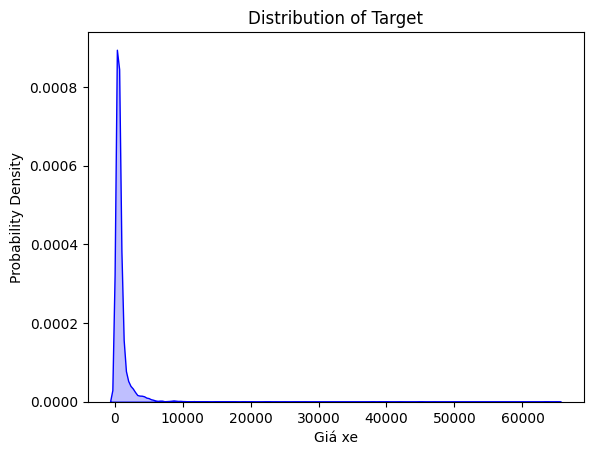

In [85]:
sns.kdeplot(data['Giá xe'],color='b', shade=True)
plt.xlabel('Giá xe')
plt.ylabel('Probability Density')
plt.title('Distribution of Target')

### Distribution of continuous variables

<ipython-input-86-94b1439e8a08>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[con_vars[i]],color='b', shade=True,ax=axes[i])
<ipython-input-86-94b1439e8a08>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[con_vars[i]],color='b', shade=True,ax=axes[i])


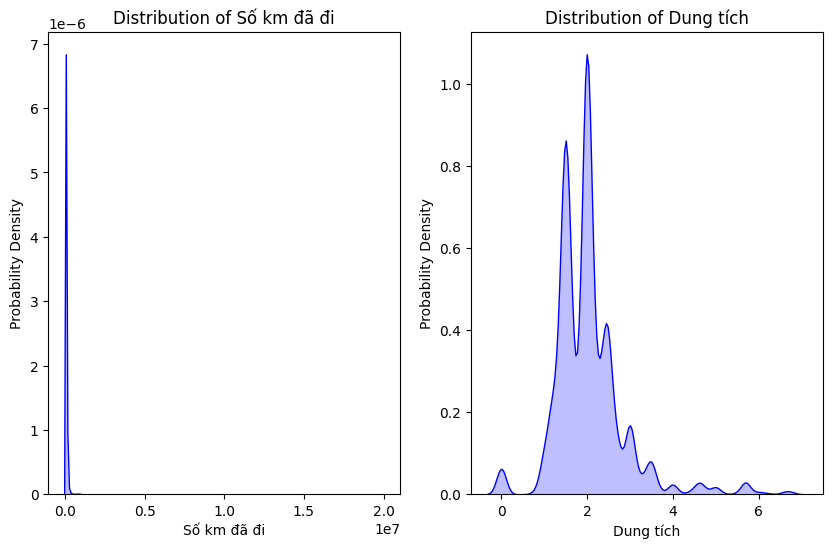

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
for i in range(len(con_vars)):
  sns.kdeplot(data[con_vars[i]],color='b', shade=True,ax=axes[i])
  axes[i].set_xlabel(con_vars[i])
  axes[i].set_ylabel('Probability Density')
  axes[i].set_title(f'Distribution of {con_vars[i]}')

<ipython-input-87-f2e5da1eec0c>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Số chỗ'],kde=False)


<Axes: xlabel='Số chỗ'>

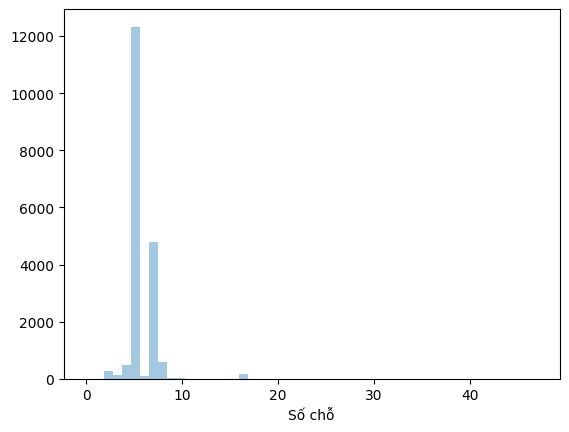

In [87]:
sns.distplot(data['Số chỗ'],kde=False)

#### Count chart of some categoricals

[]

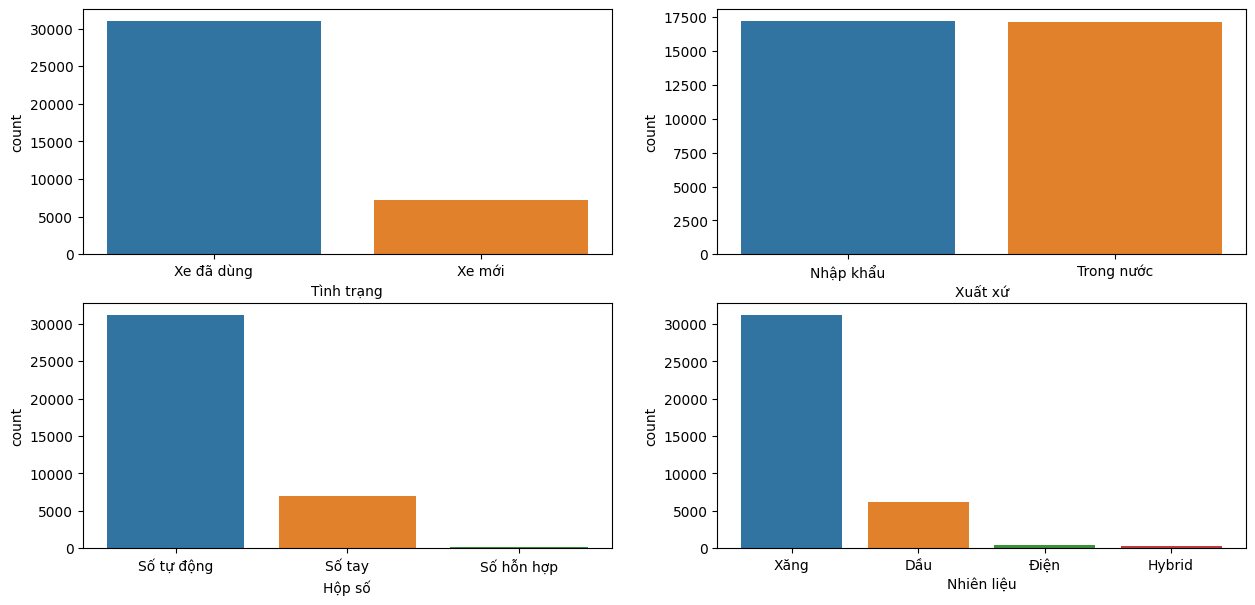

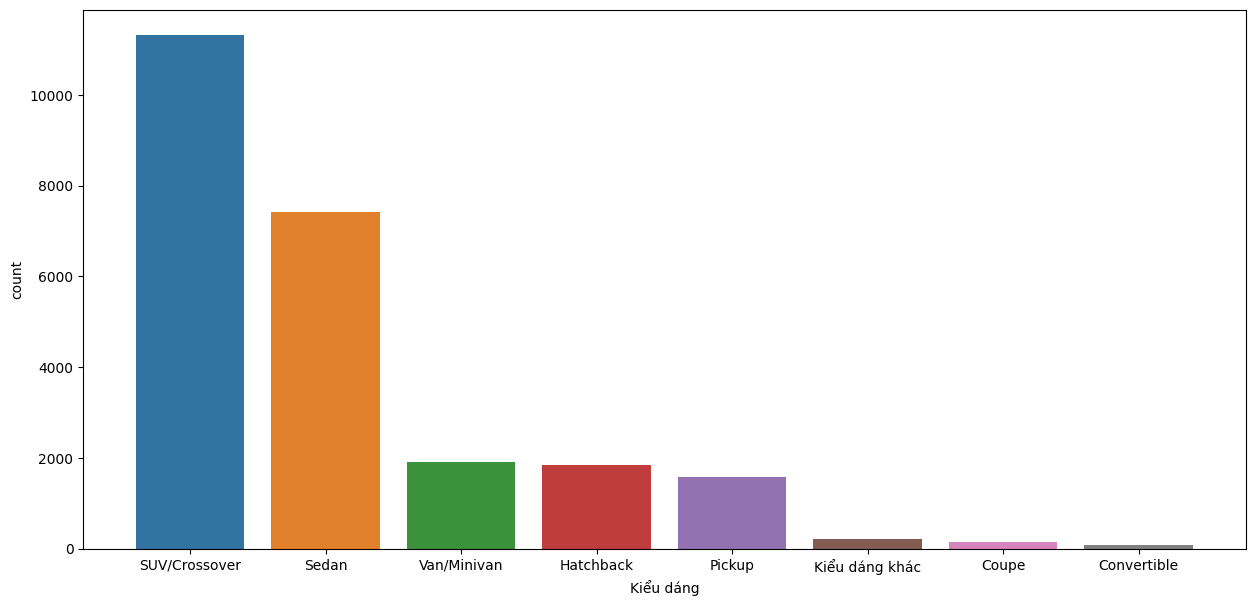

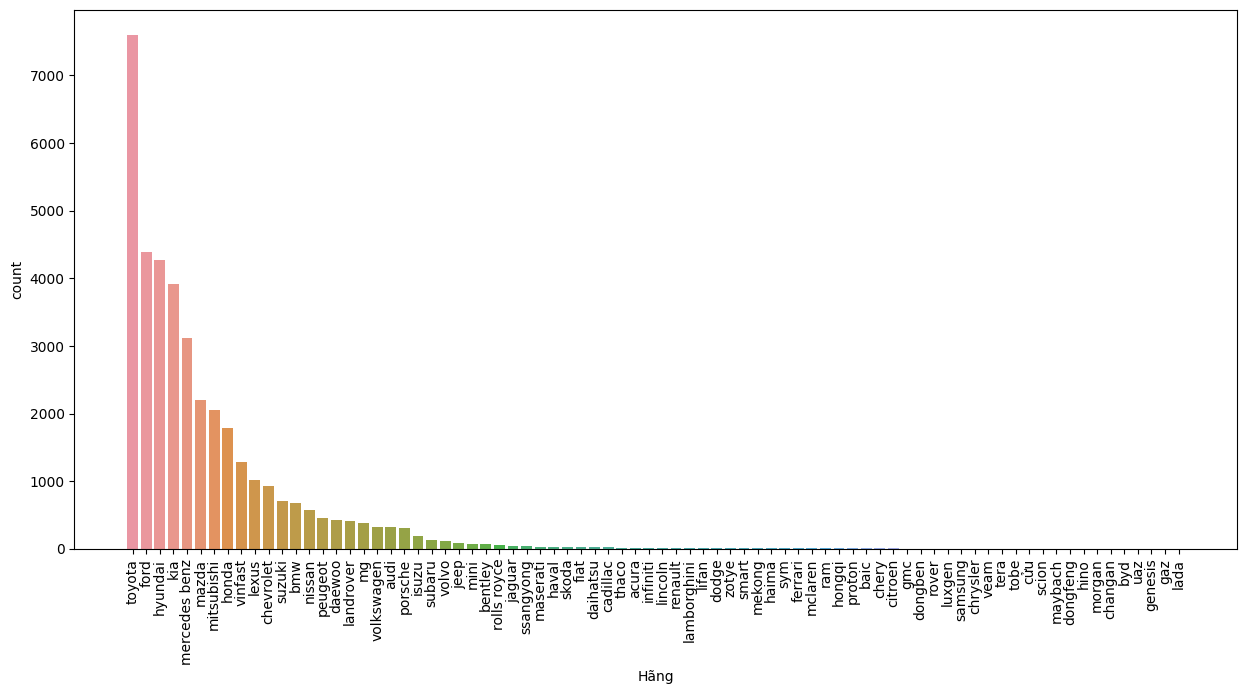

In [88]:
plt.figure(figsize=(15,7))
for i,col in enumerate(['Tình trạng', 'Xuất xứ','Hộp số', 'Nhiên liệu']):
    plt.subplot(2,2,i+1)
    sns.countplot(x=data[col], order=data[col].value_counts().index)
    plt.plot()

plt.figure(figsize=(15,7))
sns.countplot(x=data['Kiểu dáng'], order=data['Kiểu dáng'].value_counts().index)
plt.plot()

plt.figure(figsize=(15,7))
sns.countplot(x=data['Hãng'], order=data['Hãng'].value_counts().index)
plt.xticks(rotation=90)
plt.plot()

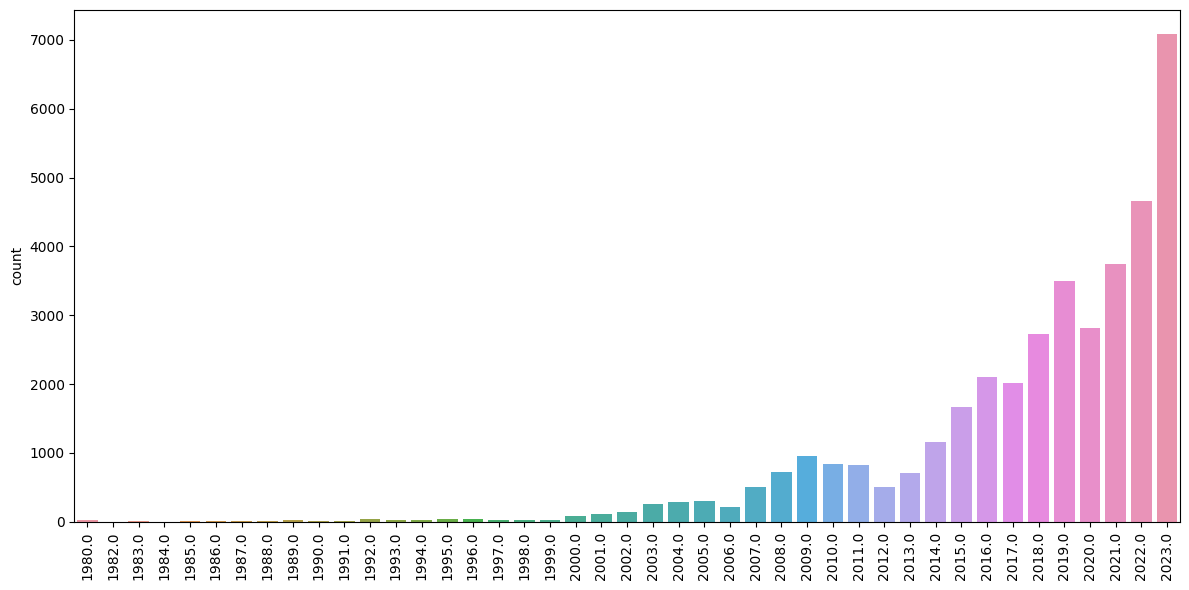

In [89]:
fig=plt.figure(figsize=(12,6))
sns.countplot(x=sorted(data['Năm sản xuất'],reverse=True))
plt.xticks(rotation=90)
fig.tight_layout()

Similar to Design, Gearbox, Fuel fields, Production Year has some values with very low frequecy compared to the remaining values. We can consider them as outliers of this field.

### Visualize distribution of target in each field

#### Distribution of **Price** in **Brand**

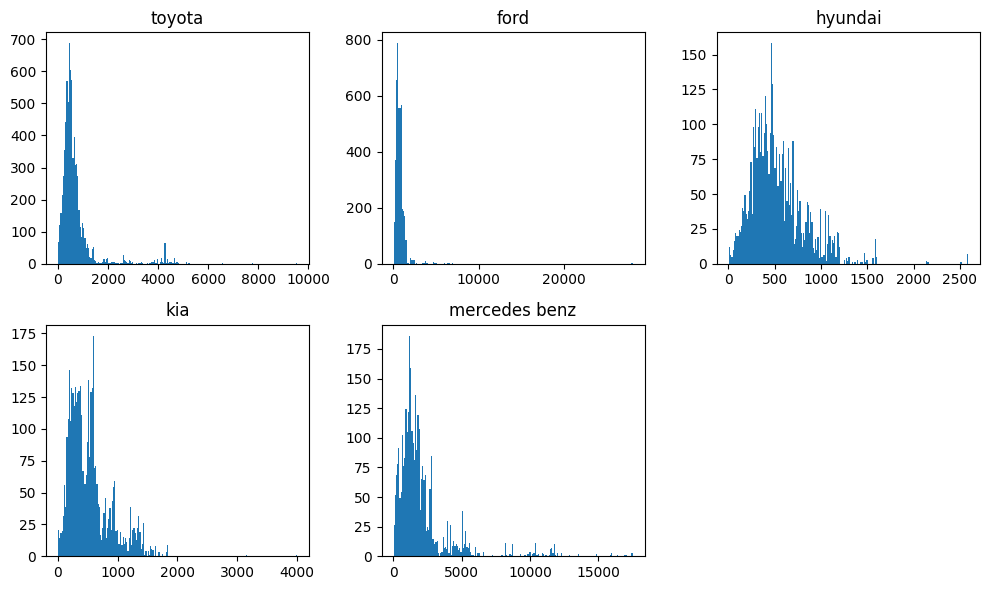

In [90]:
fig=plt.figure(figsize=(10,6))
for i,v in enumerate(['toyota','ford','hyundai','kia','mercedes benz']):
    plt.subplot(2,3,i+1)
    plt.hist(x=data['Giá xe'][data['Hãng']==v],bins=200)
    plt.title(f'{v}')
    plt.plot()
fig.tight_layout()

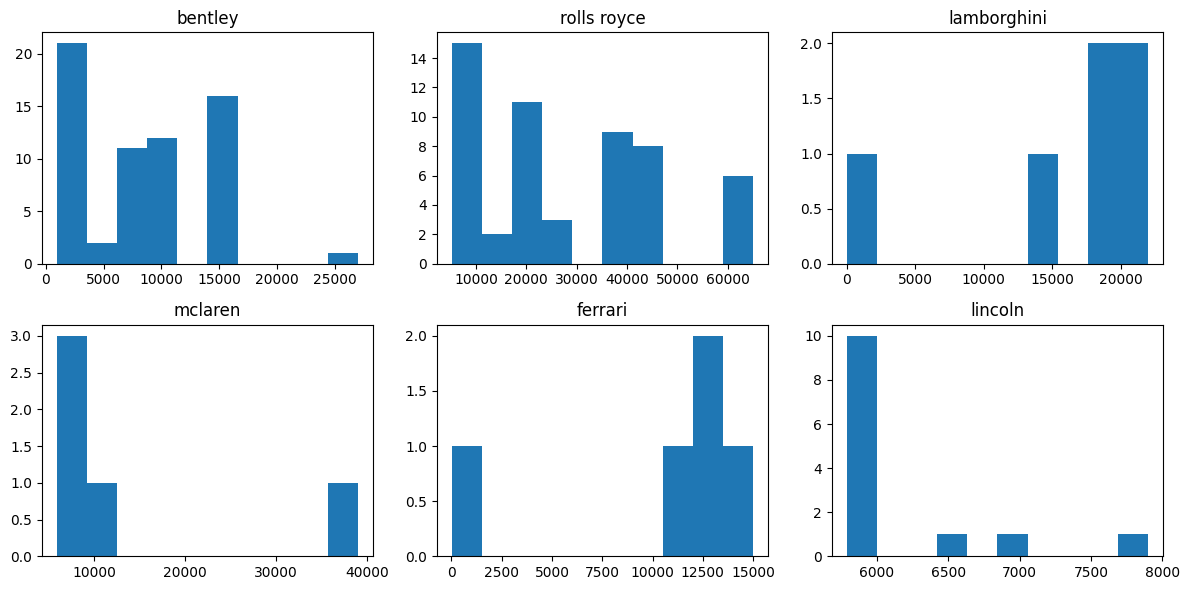

In [91]:
fig=plt.figure(figsize=(12,6))
for i,v in enumerate(['bentley','rolls royce','lamborghini','mclaren','ferrari','lincoln']):
    plt.subplot(2,3,i+1)
    plt.hist(x=data['Giá xe'][data['Hãng']==v],bins=10)
    plt.title(f'{v}')
    plt.plot()
fig.tight_layout()

The distibution of price of these brands is large compared to the distrubiton of price of other brands, but the number of cars of these brands is small, so we combine 6 brands into 'hyper car' to avoid outliers. Similar to other brands with small number of cars, we combine them to 'Khac'

Besides, after vizualing the price of each brands in hyper car, we see that there are a Ferrari car with very low price, it can be consider as outlier of dataset and we will remove this sample.

In [92]:
data[data['Hãng']=='ferrari']

,Hãng,Dòng xe,Năm sản xuất,Tình trạng,Số km đã đi,Xuất xứ,Kiểu dáng,Hộp số,Nhiên liệu,Dung tích,Số chỗ,Giá xe
13244,ferrari,f8,2022.0,Xe đã dùng,0.0,Nhập khẩu,Convertible,Số tự động,Xăng,3.9,2.0,14999
15510,ferrari,portofino,2021.0,Xe đã dùng,6000.0,Nhập khẩu,Convertible,Số tự động,Xăng,3.9,4.0,11900
23051,ferrari,dòngkhác,2015.0,Xe đã dùng,46000.0,Nhập khẩu,NaN,Số hỗn hợp,Xăng,NaN,NaN,13000
26168,ferrari,456,2001.0,Xe đã dùng,100000.0,Nhập khẩu,NaN,Số tay,Xăng,NaN,NaN,15
31833,ferrari,458,2015.0,Xe đã dùng,46000.0,Nhập khẩu,NaN,Số tự động,Xăng,NaN,NaN,13000


In [93]:
for i,v in enumerate(data['Hãng'].value_counts().index):
  num=data['Hãng'].value_counts()[i]
  print(f'{i} : {v} : {num}')

0 : toyota : 7593
1 : ford : 4387
2 : hyundai : 4273
3 : kia : 3923
4 : mercedes benz : 3115
5 : mazda : 2207
6 : mitsubishi : 2054
7 : honda : 1785
8 : vinfast : 1278
9 : lexus : 1013
10 : chevrolet : 921
11 : suzuki : 712
12 : bmw : 678
13 : nissan : 576
14 : peugeot : 461
15 : daewoo : 429
16 : landrover : 412
17 : mg : 378
18 : volkswagen : 321
19 : audi : 314
20 : porsche : 302
21 : isuzu : 184
22 : subaru : 126
23 : volvo : 109
24 : jeep : 79
25 : mini : 76
26 : bentley : 63
27 : rolls royce : 54
28 : jaguar : 35
29 : ssangyong : 33
30 : maserati : 30
31 : haval : 27
32 : skoda : 25
33 : fiat : 22
34 : daihatsu : 22
35 : cadillac : 21
36 : thaco : 17
37 : acura : 16
38 : infiniti : 15
39 : lincoln : 13
40 : renault : 8
41 : lamborghini : 6
42 : lifan : 6
43 : dodge : 6
44 : zotye : 6
45 : smart : 5
46 : mekong : 5
47 : haima : 5
48 : sym : 5
49 : ferrari : 5
50 : mclaren : 5
51 : ram : 5
52 : hongqi : 4
53 : proton : 4
54 : baic : 4
55 : chery : 4
56 : citroen : 4
57 : gmc : 3
58

#### Distribution of **Price** in **Fuel**

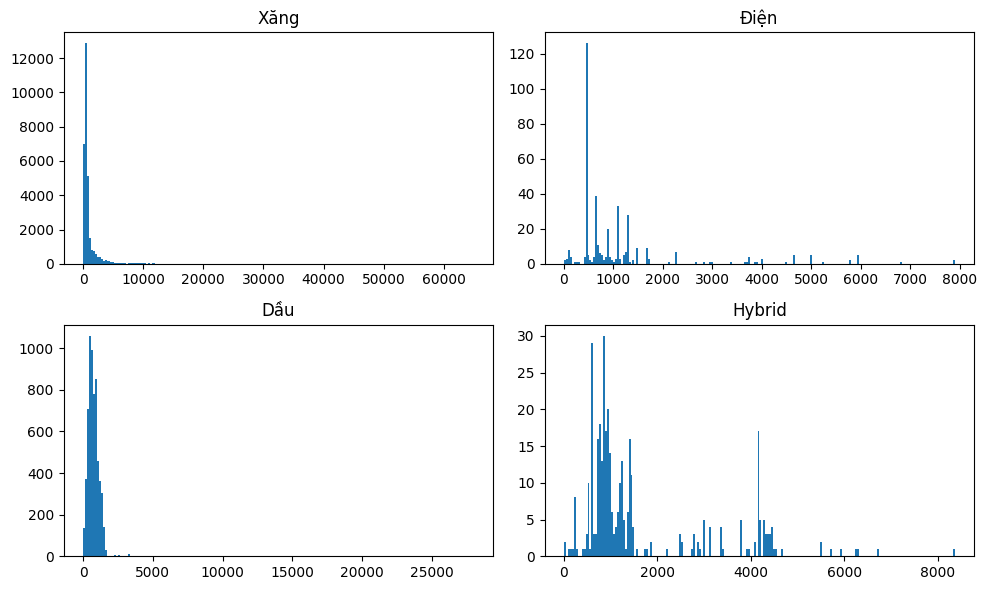

In [94]:
fig=plt.figure(figsize=(10,6))
for i,v in enumerate(np.delete(data['Nhiên liệu'].unique(),3)):
    plt.subplot(2,2,i+1)
    plt.hist(x=data['Giá xe'][data['Nhiên liệu']==v],bins=200)
    plt.title(f'{v}')
    plt.plot()
fig.tight_layout()

As mentioned above, we can consider Hybrid and Electric as outlier values in the Fuel field. However, when visualizing the price distribution of these fields, we see that the among hybrid fuel cars, of number of cars priced >= 3000 accounts for a significant number. It is quite different from the price distribution of other fuel cars when the number of cars priced >= 3,000 accounts for a very small number, insignificant part compared to the its distribution. On the other hand, with electric vehicles, if we consider them as outliers and decide to process them (delete, merge, replace...), we may have problems when reasoning in the future when the number of electric car is increasing. Therefore, we will decide to keep both Hybrid and Electric values without doing any processing.

#### Distribution of **Target** in **Gearbox**

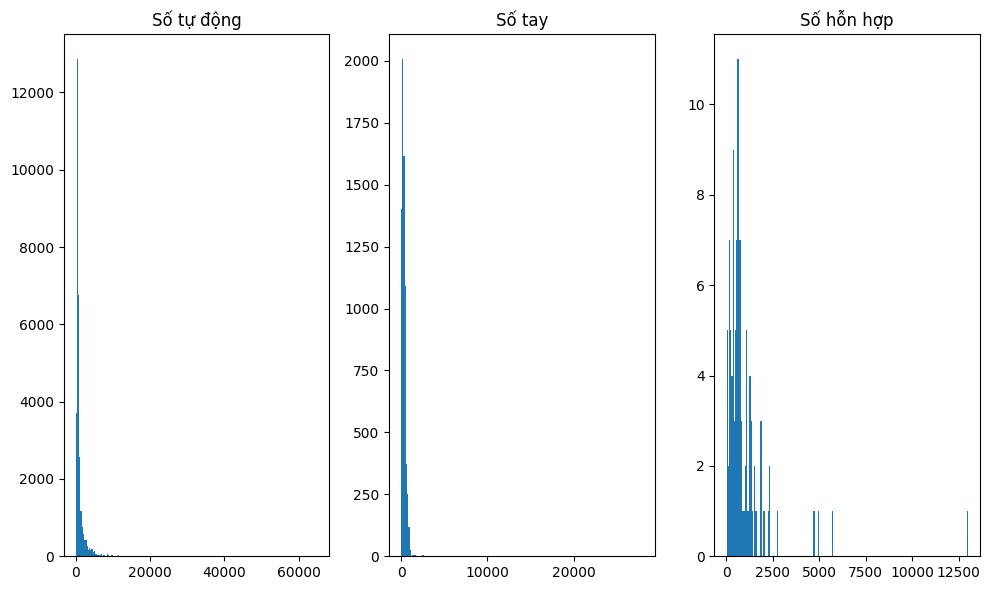

In [95]:
fig=plt.figure(figsize=(10,6))
for i,v in enumerate(np.delete(data['Hộp số'].unique(),2)):
    plt.subplot(1,3,i+1)
    plt.hist(x=data['Giá xe'][data['Hộp số']==v],bins=200)
    plt.title(f'{v}')
    plt.plot()
fig.tight_layout()

The price distribution of in mixed gearbox cars is relatively similar to mannual gaerbox cars. Moreover, the frequency of mixed gearbox car is very low compared to other types, so we can group mixed gearbox with mannual gearbox

#### Distribution of **Price** in **Kiểu dáng**

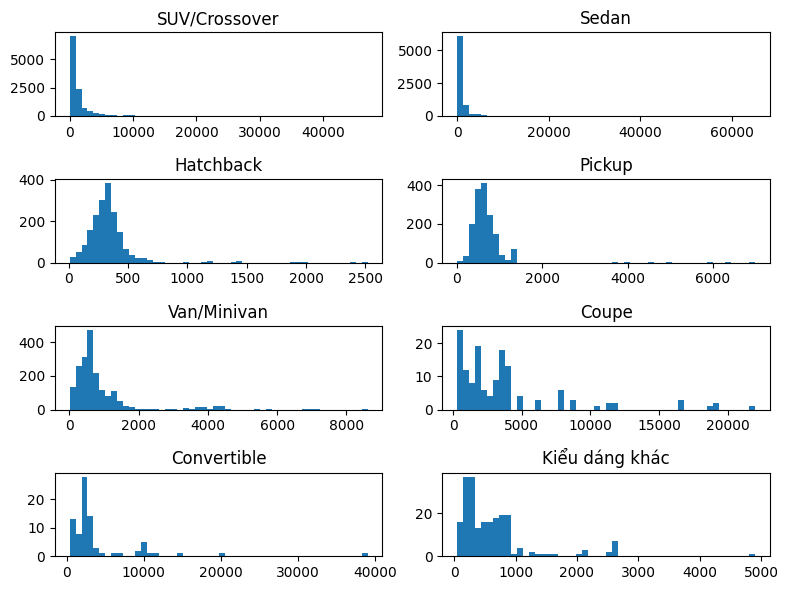

In [96]:
fig=plt.figure(figsize=(8,6))
for i,v in enumerate(np.delete(data['Kiểu dáng'].unique(),8)):
    plt.subplot(4,2,i+1)
    plt.hist(x=data['Giá xe'][data['Kiểu dáng']==v],bins=50)
    plt.title(f'{v}')
    plt.plot()
fig.tight_layout()

The distribution of 3 lowest frequecy: Coupe, Convertible and Kiểu dáng khác are relatively different from the remaining designs. Specifically, these car often have higher price than the other. So it is consider as important information that the model can learn to make more accurate predictions.

#### Distribution of **Price** in **Production Year**

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

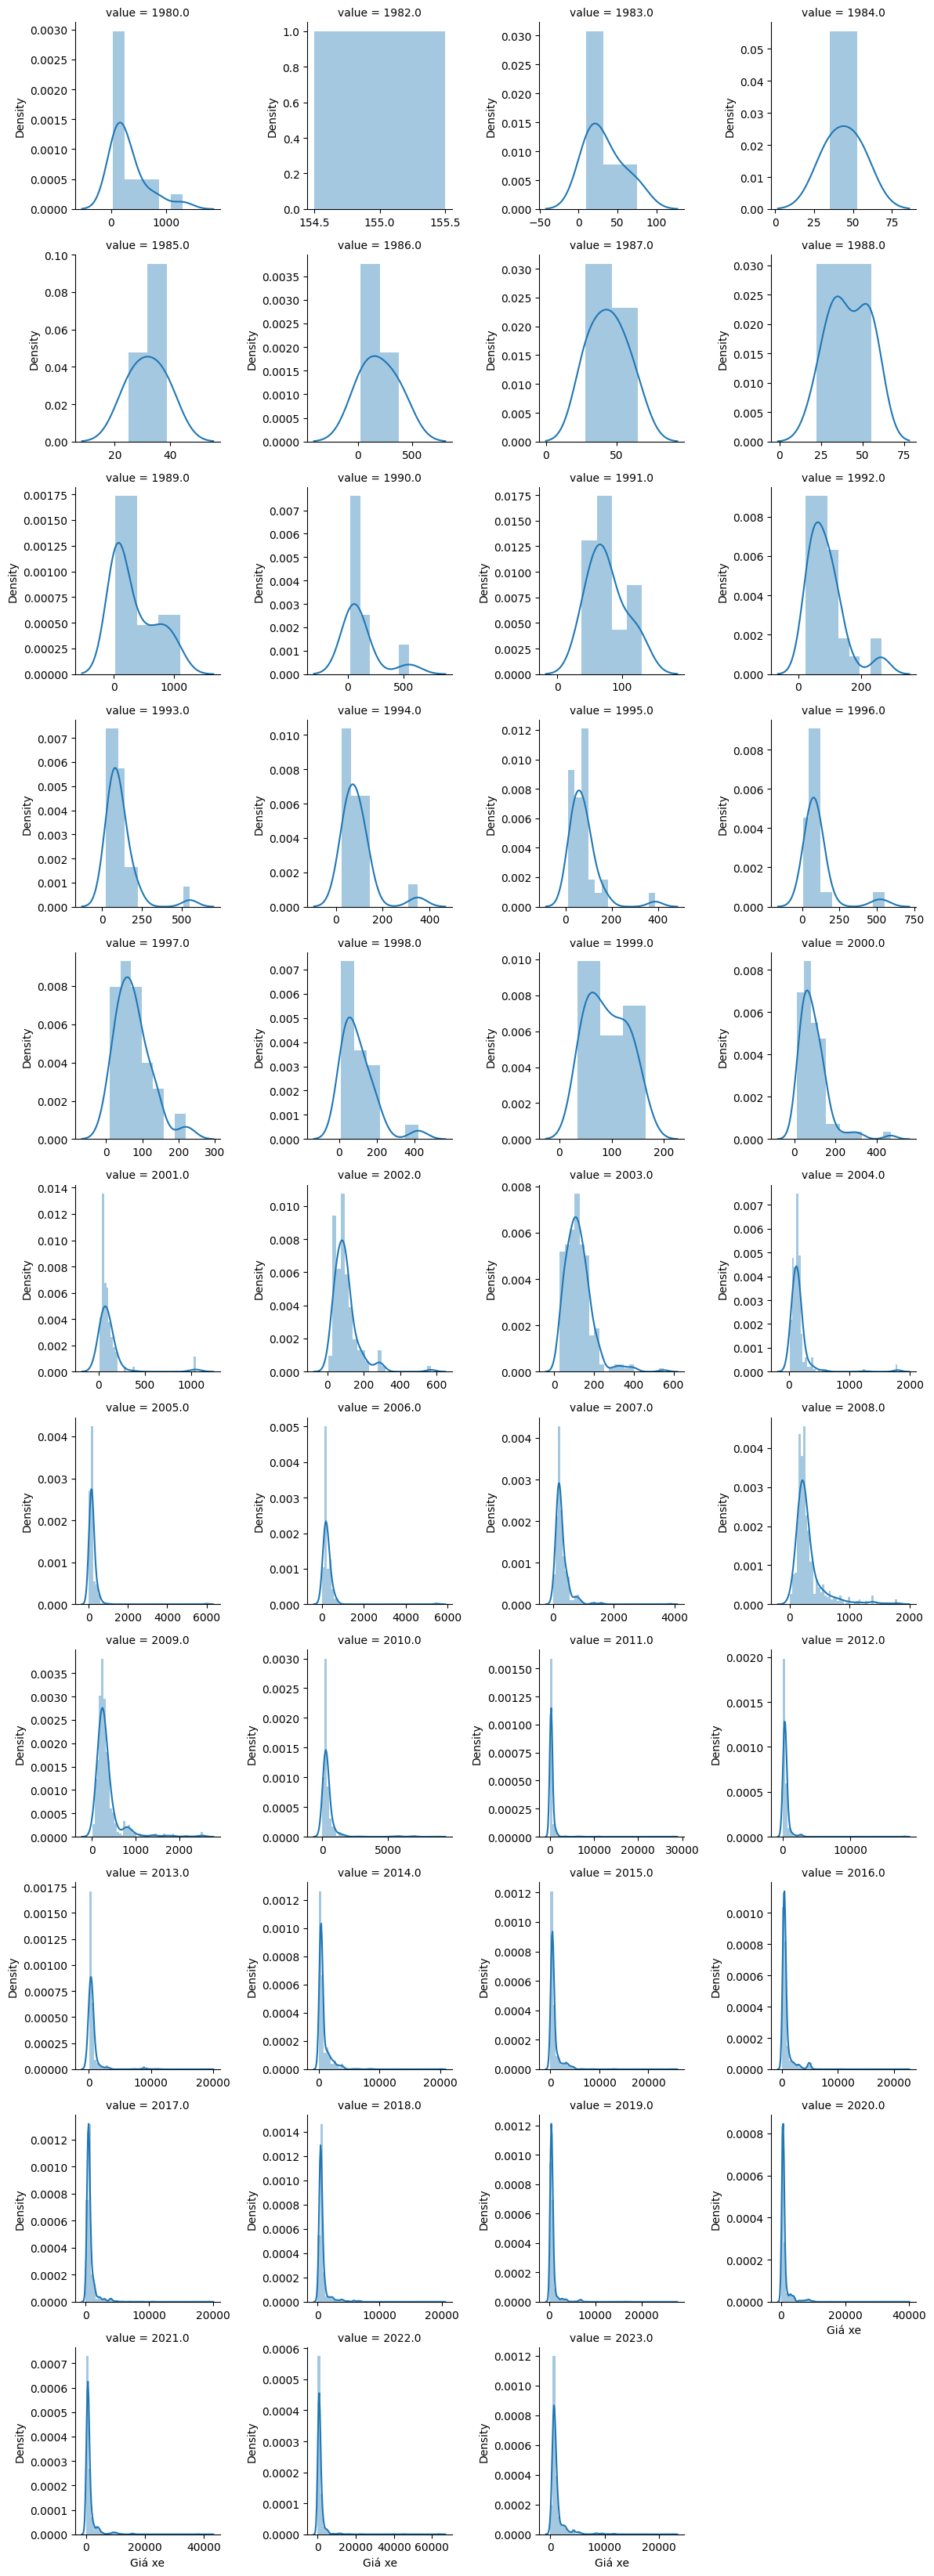

In [97]:
data1=data.sort_values(by='Năm sản xuất',axis=0)
f3=pd.melt(data1,id_vars='Giá xe',value_vars='Năm sản xuất')
graph=sns.FacetGrid(f3,col='value',col_wrap=4,sharex=False,sharey=False)
graph.map(sns.distplot,'Giá xe')

The distribution of price in 2 consecutive year is almost similar so we can bind some consecutive year with low distribution into one to hadle outliers.

### Boxplot

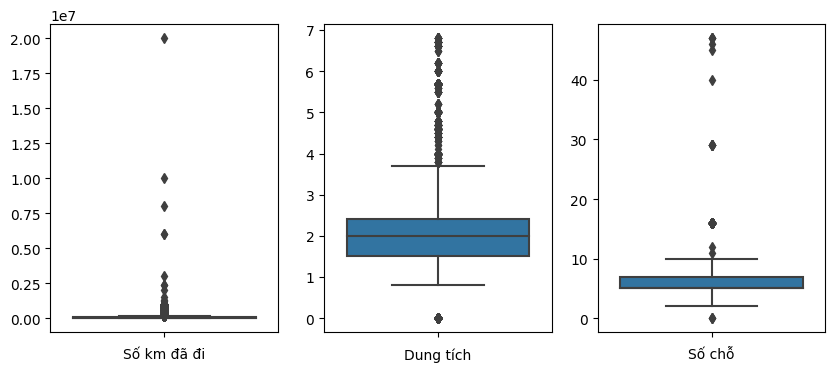

In [98]:
fig, axes = plt.subplots(1,3, figsize=(10, 4))
for i,cols in enumerate(num_vars):
    sns.boxplot(y=cols,data=data,ax=axes[i])
    axes[i].set_xlabel(cols)
    axes[i].set_ylabel('')
plt.show()

The number of kms traveled in most of cars is 0 mean that most of cars in dataset is new. Moreover,most of cars have capacity <= 3, especially he number of cars with capacity >= 6 is very low, they can be consider as outliers. Similarly, most the number of seats in most of cars is < 10, and the remaining can be consider as outliers. We can handle these outlier to avoid bad effect to model but if they bring important information, they can be retained.

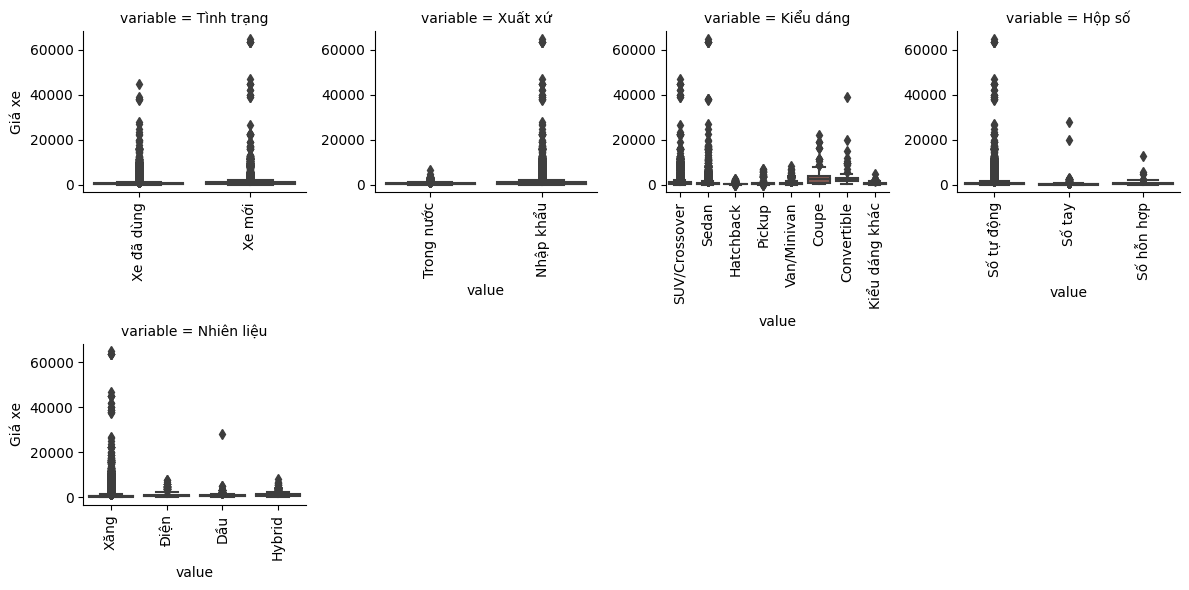

In [99]:
c_vars=[i for i in cat_vars if i not in ['Hãng','Năm sản xuất','Dòng xe']]
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    x=plt.xticks(rotation=90)
f2=pd.melt(data,id_vars='Giá xe',value_vars=c_vars)
graph=sns.FacetGrid(f2,col='variable',col_wrap=4,sharex=False,sharey=False)
graph.map(boxplot,'value','Giá xe')

## Data Preparation

### Handle missing values

In [100]:
data.isnull().sum()

Hãng                0
Dòng xe             0
Năm sản xuất        0
Tình trạng          0
Số km đã đi       258
Xuất xứ          3862
Kiểu dáng       13744
Hộp số              8
Nhiên liệu          7
Dung tích       14913
Số chỗ          19352
Giá xe              0
dtype: int64

For fields that the number of missing value are small like Gearbox or Fuel, we drop all car having missing value in these field

In [101]:
data.dropna(subset=['Hộp số', 'Nhiên liệu'],inplace=True)

For the remain field, we fill missing values by imputor

In [102]:
#Fill number of kms traveled by mean group by Production year
data['Số km đã đi'] = data.groupby('Năm sản xuất')['Số km đã đi'].transform(lambda x:x.fillna(x.mean()))

In [103]:
#fill remaining column by mode group by Brand and Series
vars=['Xuất xứ','Kiểu dáng','Dung tích','Số chỗ']
data[vars] = data.groupby(['Dòng xe','Hãng'])[vars].transform(lambda x:x.fillna(x.mode().iloc[0]))

After filling by mode, there are still some missing value, because mode of some field is already null. So for the remaining missing value, we fill by the mode but without group by any other fields

In [104]:
data[vars] = data[vars].transform(lambda x:x.fillna(x.mode().iloc[0]))

### Handle outliers

#### Handle categorical outliers

In [105]:
#Remove outlier in target of Ferrari brand
data.drop(data[(data['Hãng'] == 'ferrari') & (data['Giá xe'] < 100)].index, inplace=True)

In [106]:
#Convert 2 type of gearbox with very small quantity to 1 label 'Khác'
data.loc[data['Hộp số']=='Số hỗn hợp','Hộp số']='Khác'
data.loc[data['Hộp số']=='Số tay','Hộp số']='Khác'

In [107]:
#Binning Production Year
def bin_year(x):
  if 1980<=int(x)<=2000 :
    x='1980-2000'
  elif 2001 <=int(x)<=2005:
    x='2001-2005'
  elif 2006 <=int(x)<=2010 :
    x='2006-2010'
  return str(x)
data['Năm sản xuất']=data['Năm sản xuất'].apply(bin_year)

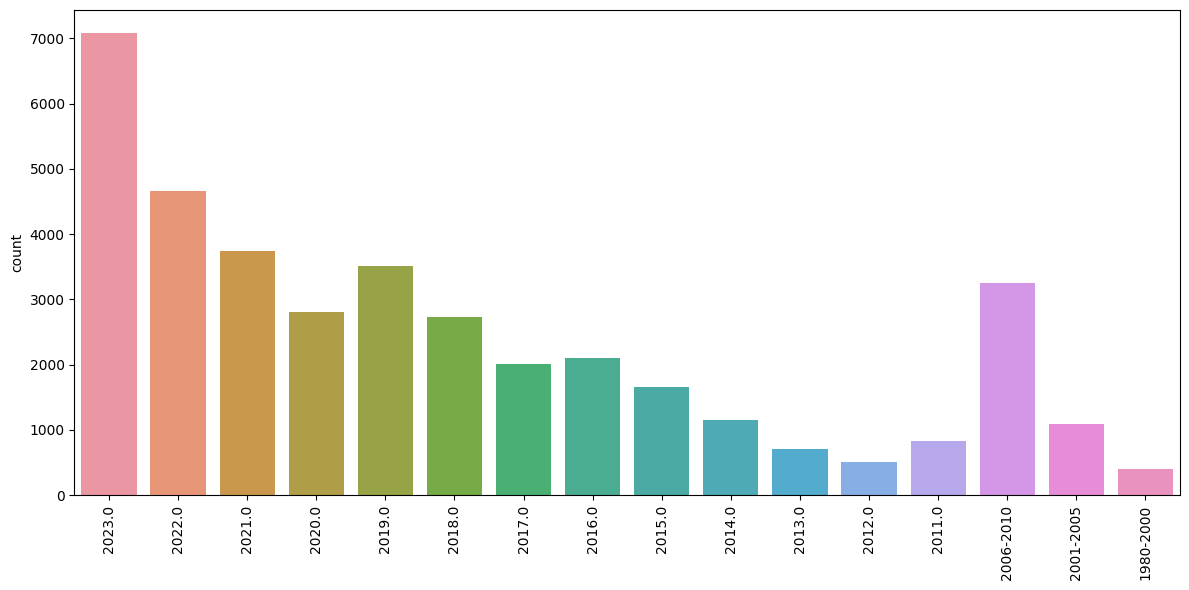

In [108]:
#Countplot of Production Year after binning
fig=plt.figure(figsize=(12,6))
sns.countplot(x=sorted(data['Năm sản xuất'],reverse=True))
plt.xticks(rotation=90)
fig.tight_layout()

In [109]:
#Convert the brand of 6 highest price with small quantity to label 'Hyper car'
for c in ['bentley','rolls royce','lamborghini','mclaren','ferrari','lincoln']:
  data['Hãng'].replace({c:'hyper car'},inplace=True)
#Convert the remaining brand with small quantity to label 'Hãng khác'
for v in (data['Hãng'].value_counts().index[26::]):
  if v not in ['bentley','rolls royce','lamborghini','mclaren','ferrari','lincoln']:
    data['Hãng'].replace({v:'hãng khác'},inplace=True)

[]

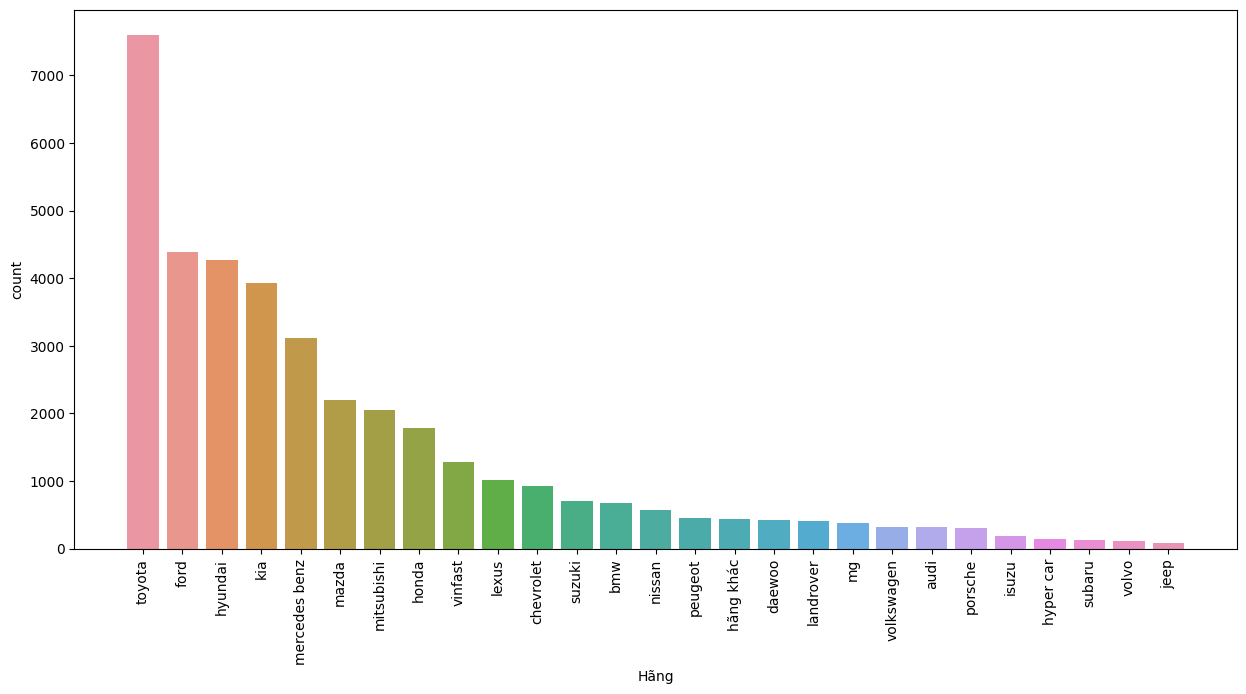

In [110]:
plt.figure(figsize=(15,7))
sns.countplot(x=data['Hãng'], order=data['Hãng'].value_counts().index)
plt.xticks(rotation=90)
plt.plot()

#### Handle numerical outliers

From the boxplot of Number of seats fields, we see that there are very few car with > 20 seats. All of them have design Van/Minivan but in fact, this design only belongs to brands with medium size, from 9 to 16 seats. Maybe, the design of this brand is labeled wrongly. Moreover, we know that the car with number of seats >= 20 is call 'chở khách' so we relabel design for these cars.

In [111]:
data[data['Số chỗ']>20]

,Hãng,Dòng xe,Năm sản xuất,Tình trạng,Số km đã đi,Xuất xứ,Kiểu dáng,Hộp số,Nhiên liệu,Dung tích,Số chỗ,Giá xe
3197,hyundai,county,2006-2010,Xe đã dùng,300000.0,Trong nước,Van/Minivan,Khác,Dầu,3.9,29.0,275
4430,hyundai,space,2001-2005,Xe đã dùng,50000.0,Nhập khẩu,Van/Minivan,Khác,Dầu,2.0,46.0,235
4680,hyundai,county,2006-2010,Xe đã dùng,0.0,Trong nước,Van/Minivan,Khác,Dầu,3.9,29.0,379
6163,hyundai,universe,2012.0,Xe đã dùng,180000.0,Trong nước,Van/Minivan,Khác,Dầu,2.0,47.0,1400
6317,hyundai,universe,2015.0,Xe đã dùng,200000.0,Trong nước,Van/Minivan,Khác,Dầu,2.0,47.0,755
11700,isuzu,samco,2014.0,Xe đã dùng,0.0,Trong nước,Van/Minivan,Khác,Dầu,2.0,29.0,740
12683,isuzu,samco,2015.0,Xe đã dùng,0.0,Trong nước,Van/Minivan,Khác,Dầu,2.0,29.0,646
13290,hyundai,universe,2015.0,Xe đã dùng,150000.0,Trong nước,Van/Minivan,Khác,Dầu,2.0,45.0,990
14214,hyundai,county,2023.0,Xe mới,0.0,Trong nước,Van/Minivan,Khác,Dầu,3.9,29.0,1500
16202,isuzu,samco,2013.0,Xe đã dùng,0.0,Trong nước,Van/Minivan,Khác,Dầu,2.0,29.0,548


In [112]:
data.loc[data['Số chỗ'] >= 20, 'Kiểu dáng'] = 'Chở khách'

From now, transformers we use need calculate and  use statistical argument của dataset so we need to split dataset into train, valid and test

In [113]:
y=data['Giá xe']
X=data.drop('Giá xe',axis=1)
X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,test_size=0.4,random_state=42)
X_val, X_test , y_val, y_test = train_test_split(X_val_test, y_val_test,test_size=0.5,random_state=42)

In [114]:
def find_boxplot_boundaries(
    col: pd.DataFrame, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    """Findx minimum and maximum in boxplot.
    Args:
        col: a pandas dataframe of input.
        whisker_coeff: whisker coefficient in box plot
    """
    Q1 = col.quantile(0.25).to_numpy()
    Q3 = col.quantile(0.75).to_numpy()
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper

class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None
    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self
    def transform(self, X):
        return X.clip(self.lower, self.upper)

In [115]:
#handle outliers with continuous variable
boc = BoxplotOutlierClipper()
X_train[con_vars]=boc.fit_transform(X_train[con_vars])
X_val[con_vars]=boc.transform(X_val[con_vars])
X_test[con_vars]=boc.transform(X_test[con_vars])

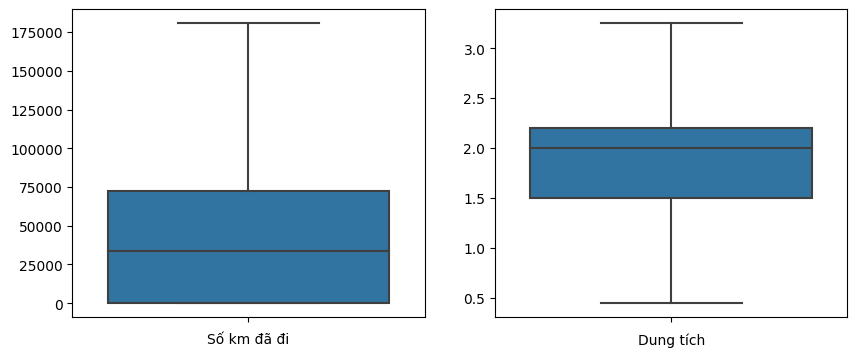

In [116]:
#boxplot of continuous variables after handling outliers
fig, axes = plt.subplots(1,2, figsize=(10, 4))
for i,cols in enumerate(con_vars):
    sns.boxplot(y=cols,data=X_train,ax=axes[i])
    axes[i].set_xlabel(cols)
    axes[i].set_ylabel('')
plt.show()

### Feature selection

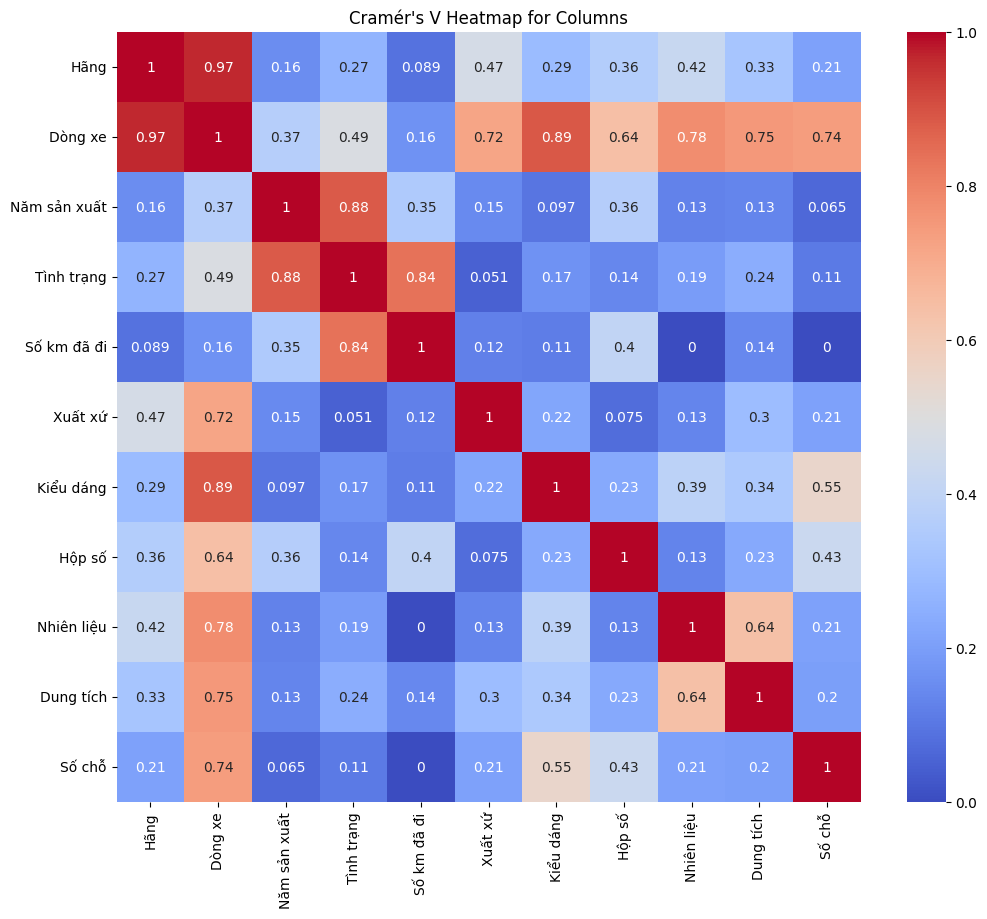

In [117]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

cramers_matrix = pd.DataFrame(index=X_train.columns, columns=X_train.columns)
for var1 in X_train.columns:
    for var2 in X_train.columns:
        confusion_matrix = pd.crosstab(X_train[var1], X_train[var2])
        cramers_matrix.loc[var1, var2] = cramers_v(confusion_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(cramers_matrix.astype(float), annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title('Cramér\'s V Heatmap for Columns')
plt.show()

Series field has high correlation with Brand field and Design field, 0.95 and 0.89 respectively. Moreover, State field also has high correlation with Number of kms traveled field (0.84) and Production Year field (0.88). Therefore, we remove 2 fields: Series and State to avoid multi-collinear phenomenon.

In [118]:
X_train.drop(['Dòng xe', 'Tình trạng'],axis=1,inplace=True)
X_val.drop(['Dòng xe', 'Tình trạng'],axis=1,inplace=True)
X_test.drop(['Dòng xe', 'Tình trạng'],axis=1,inplace=True)

### Data encoding and scaling

In [119]:
X_train.head()

,Hãng,Năm sản xuất,Số km đã đi,Xuất xứ,Kiểu dáng,Hộp số,Nhiên liệu,Dung tích,Số chỗ
16943,vinfast,2021.0,12000.0,Trong nước,Hatchback,Số tự động,Xăng,1.40,5.0
20777,chevrolet,2018.0,48000.0,Nhập khẩu,Hatchback,Khác,Xăng,1.20,5.0
7816,toyota,2016.0,73000.0,Nhập khẩu,SUV/Crossover,Số tự động,Xăng,3.25,8.0
25269,volvo,2022.0,37000.0,Nhập khẩu,SUV/Crossover,Số tự động,Hybrid,2.00,5.0
33047,chevrolet,2017.0,80000.0,Nhập khẩu,Hatchback,Khác,Xăng,1.20,5.0


In [120]:
X_train.dtypes

Hãng             object
Năm sản xuất     object
Số km đã đi     float64
Xuất xứ          object
Kiểu dáng        object
Hộp số           object
Nhiên liệu       object
Dung tích       float64
Số chỗ          float64
dtype: object

#### Encode categorical field

In [121]:
encoder= ColumnTransformer(transformers=[('ordinal encoding',JamesSteinEncoder(),[1]),
                                         ('nominal encoding',OneHotEncoder(sparse_output= False),[0,3,4,5,6])],remainder = 'passthrough')

#### Scale numerical field

In [122]:
normalization=ColumnTransformer(transformers=[('normalization',StandardScaler(),[1,2,7,8])],remainder = 'passthrough')

## Modeling

#### Ridge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.93624e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


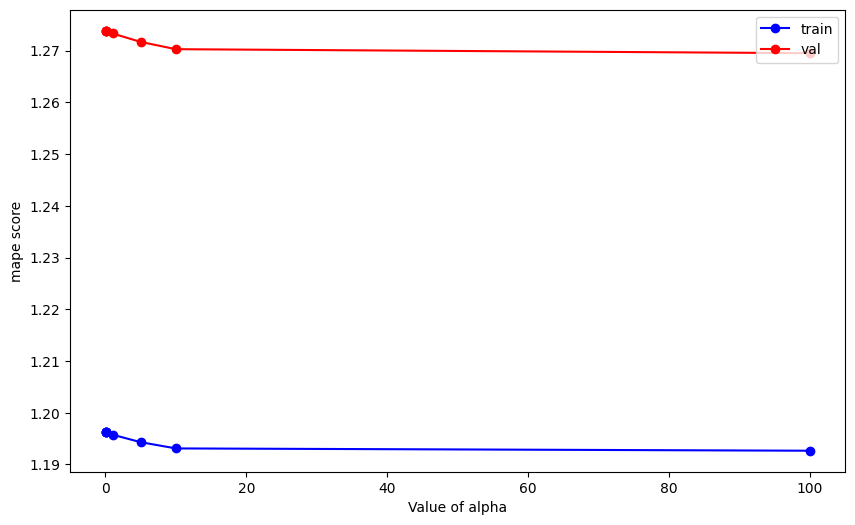

In [123]:
alpha_values=[0.001,0.01,0.05,0.1,1,5,10,100]
mape_score_train=[]
mape_score_val=[]


for alpha in alpha_values:
    model_ridge=Ridge(alpha=alpha)
    pipeline_ridge=Pipeline([('step1',encoder),('step2',normalization),('step3',model_ridge)])

    pipeline_ridge.fit(X_train, y_train)
    train_pred_ridge=pipeline_ridge.predict(X_train)
    val_pred_ridge = pipeline_ridge.predict(X_val)

    # Calculate R2 score and mean absolute error
    mape_score_train.append(mean_absolute_percentage_error(y_train,train_pred_ridge))
    mape_score_val.append(mean_absolute_percentage_error(y_val,val_pred_ridge))
plt.figure(figsize=(10,6))
plt.plot(alpha_values,mape_score_train,color='b',marker='o',label='train')
plt.plot(alpha_values,mape_score_val,color='r',marker='o',label='val')
plt.xlabel('Value of alpha')
plt.ylabel('mape score')
plt.legend(loc='upper right', fontsize='medium')
plt.show()

In [125]:
best_model_ridge=Ridge(alpha=0.1)
pipeline_ridge=Pipeline([('step1',encoder),('step2',normalization),('step3',best_model_ridge)])
pipeline_ridge.fit(X_train,y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal encoding',
                                                  JamesSteinEncoder(), [1]),
                                                 ('nominal encoding',
                                                  OneHotEncoder(sparse_output=False),
                                                  [0, 3, 4, 5, 6])])),
                ('step2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('normalization',
                                                  StandardScaler(),
                                                  [1, 2, 7, 8])])),
                ('step3', Ridge(alpha=0.1))])

In [126]:
test_pred_ridge=pipeline_ridge.predict(X_test)
mape_ridge=mean_absolute_percentage_error(y_test,test_pred_ridge)

#### Random Forest

In [127]:
model_rf=RandomForestRegressor()

In [128]:
pipeline_rf=Pipeline([('step1',encoder),('step2',normalization),('step3',model_rf)])

In [129]:
para_grid_rf_tune={'step3__n_estimators':[50,100,200,500],
                   'step3__max_depth':[None,2,4,6],
                   'step3__max_features':[1,'sqrt','log2'],
                   'step3__max_leaf_nodes':[None,2,4,6]}

In [130]:
grid_search_rf= GridSearchCV(pipeline_rf,para_grid_rf_tune, cv=5, scoring='neg_mean_absolute_percentage_error')
grid_search_rf.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('step1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal '
                                                                         'encoding',
                                                                         JamesSteinEncoder(),
                                                                         [1]),
                                                                        ('nominal '
                                                                         'encoding',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         [0, 3,
                                                                          4, 5,
                                                                          6])])),
                                       ('step2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('normalization',
                                                                         StandardScaler(),
                                                                         [1, 2,
                                                                          7,
                                                                          8])])),
                                       ('step3', RandomForestRegressor())]),
             param_grid={'step3__max_depth': [None, 2, 4, 6],
                         'step3__max_features': [1, 'sqrt', 'log2'],
                         'step3__max_leaf_nodes': [None, 2, 4, 6],
                         'step3__n_estimators': [50, 100, 200, 500]},
             scoring='neg_mean_absolute_percentage_error')

In [131]:
best_params_rf = grid_search_rf.best_params_
print(f'best hyper parameters set is : {best_params_rf}')


best hyper parameters set is : {'step3__max_depth': None, 'step3__max_features': 'log2', 'step3__max_leaf_nodes': None, 'step3__n_estimators': 100}


In [132]:
grid_search_rf.best_estimator_

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal encoding',
                                                  JamesSteinEncoder(), [1]),
                                                 ('nominal encoding',
                                                  OneHotEncoder(sparse_output=False),
                                                  [0, 3, 4, 5, 6])])),
                ('step2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('normalization',
                                                  StandardScaler(),
                                                  [1, 2, 7, 8])])),
                ('step3', RandomForestRegressor(max_features='log2'))])

In [135]:
best_model_rf=RandomForestRegressor(max_features='log2',n_estimators=100)

In [133]:
test_pred_rf=grid_search_rf.best_estimator_.predict(X_test)
mape_rf=mean_absolute_percentage_error(y_test,test_pred_rf)

In [134]:
mape_rf

0.3015456432110841

#### KNN

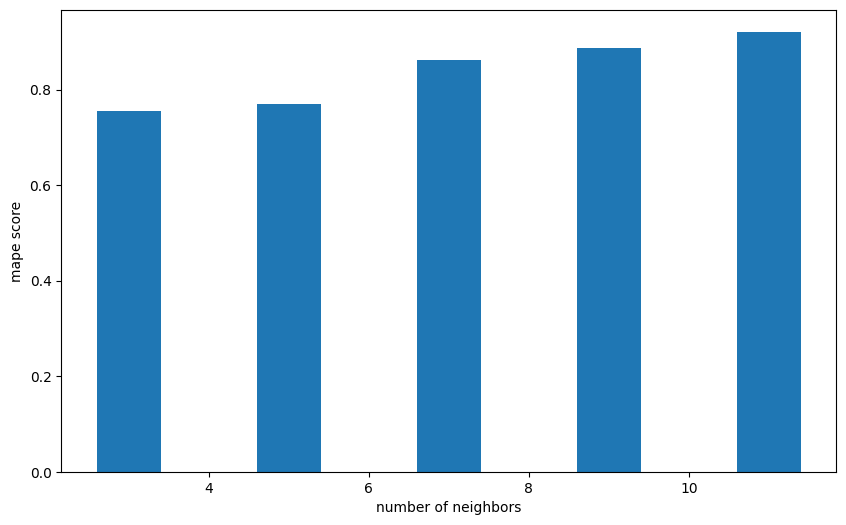

In [136]:
n_neighbor=[3,5,7,9,11]
mape_scores=[]
neighbors=[]

for neighbor in n_neighbor:
    model_knn=KNeighborsRegressor(n_neighbors=neighbor)
    pipeline_knn=Pipeline([('step1',encoder),('step2',normalization),('step3',model_knn)])

    pipeline_knn.fit(X_train, y_train)
    val_pred_knn = pipeline_knn.predict(X_val)

    # Calculate R2 score and mean absolute error
    mape_scores.append(mean_absolute_percentage_error(y_val,val_pred_knn))
plt.figure(figsize=(10,6))
plt.bar(n_neighbor,mape_scores)
plt.xlabel('number of neighbors')
plt.ylabel('mape score')
plt.show()

có thể thấy với số neighbor càng nhỏ thì MAPE cũng càng nhỏ (càng tốt) tuy nhiên để tránh overfitting,chúng ta sẽ chọn neighbor=5

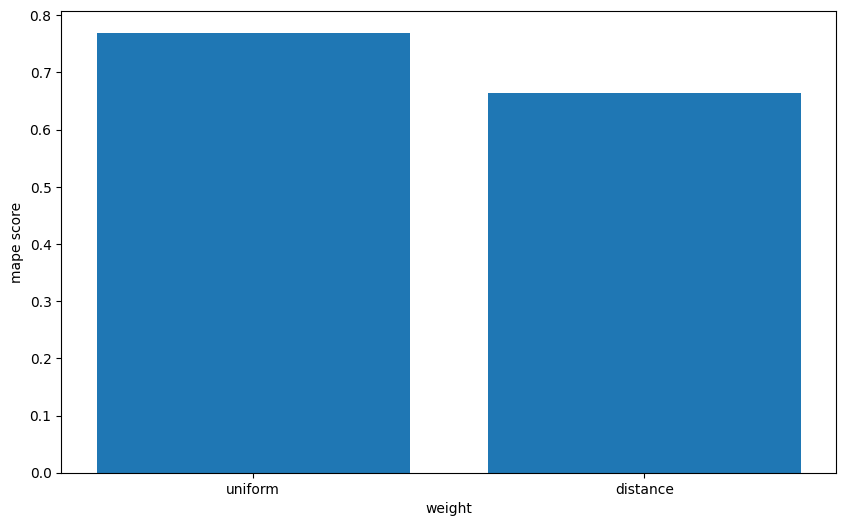

In [137]:
weight=['uniform','distance']
mape_scores=[]


for w in weight:
    model_knn=KNeighborsRegressor(n_neighbors=5,weights=w)
    pipeline_knn=Pipeline([('step1',encoder),('step2',normalization),('step3',model_knn)])

    pipeline_knn.fit(X_train, y_train)
    val_pred_knn = pipeline_knn.predict(X_val)

    # Calculate R2 score and mean absolute error
    mape_scores.append(mean_absolute_percentage_error(y_val,val_pred_knn))
plt.figure(figsize=(10,6))
plt.bar(weight,mape_scores)
plt.xlabel('weight')
plt.ylabel('mape score')
plt.show()

dễ thấy weights tối ưu ở đây được chọn sẽ là distance

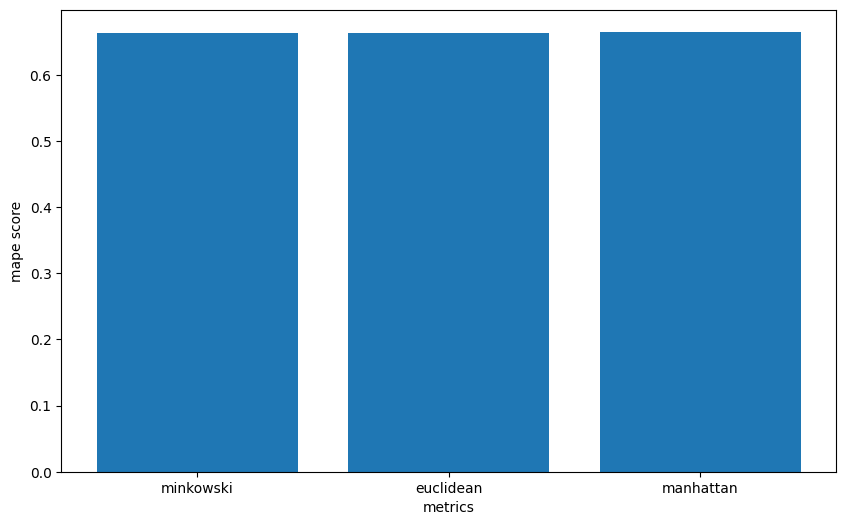

In [138]:
metrics=['minkowski','euclidean','manhattan']
mape_scores=[]
for m in metrics:
    model_knn=KNeighborsRegressor(n_neighbors=5,weights='distance',metric=m)
    pipeline_knn=Pipeline([('step1',encoder),('step2',normalization),('step3',model_knn)])

    pipeline_knn.fit(X_train, y_train)
    val_pred_knn = pipeline_knn.predict(X_val)

    # Calculate R2 score and mean absolute error
    mape_scores.append(mean_absolute_percentage_error(y_val,val_pred_knn))
plt.figure(figsize=(10,6))
plt.bar(metrics,mape_scores)
plt.xlabel('metrics')
plt.ylabel('mape score')
plt.show()

In [139]:
best_model_knn=KNeighborsRegressor(n_neighbors=5,weights='distance',metric='minkowski')
pipeline_knn=Pipeline([('step1',encoder),('step2',normalization),('step3',best_model_knn)])
pipeline_knn.fit(X_train,y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal encoding',
                                                  JamesSteinEncoder(), [1]),
                                                 ('nominal encoding',
                                                  OneHotEncoder(sparse_output=False),
                                                  [0, 3, 4, 5, 6])])),
                ('step2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('normalization',
                                                  StandardScaler(),
                                                  [1, 2, 7, 8])])),
                ('step3', KNeighborsRegressor(weights='distance'))])

In [140]:
test_pred_knn=pipeline_knn.predict(X_test)
mape_knn=mean_absolute_percentage_error(y_test,test_pred_knn)

In [141]:
mape_knn

0.4727605047296789

#### XGBoost

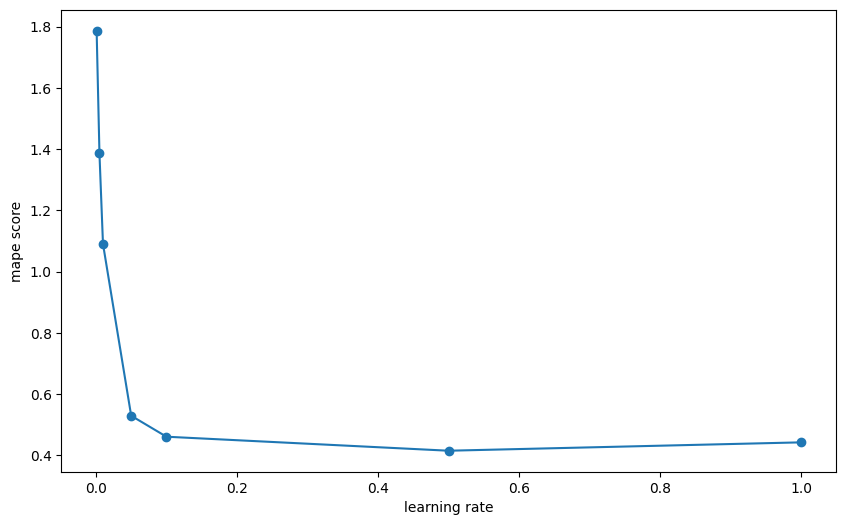

In [142]:
lr=[0.001,0.005,0.01,0.05,0.1,0.5,1]
mape_scores=[]


for i in lr:
    model_xgb=XGBRegressor(learning_rate=i)
    pipeline_xgb=Pipeline([('step1',encoder),('step2',normalization),('step3',model_xgb)])

    pipeline_xgb.fit(X_train, y_train)
    val_pred_xgb = pipeline_xgb.predict(X_val)

    # Calculate R2 score and mean absolute error
    mape_scores.append(mean_absolute_percentage_error(y_val,val_pred_xgb))
plt.figure(figsize=(10,6))
plt.plot(lr,mape_scores,marker='o')
plt.xlabel('learning rate')
plt.ylabel('mape score')
plt.show()

dễ thấy ta sẽ chọn với lr=0.5 để có mape tốt nhất trên tập validiation

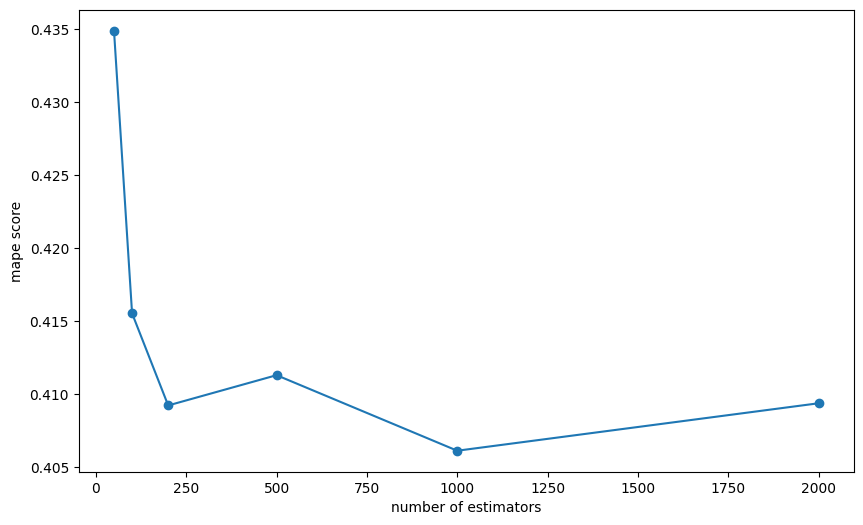

In [143]:
n_estimator=[50,100,200,500,1000,2000]
mape_scores=[]


for tree in n_estimator:
    model_xgb=XGBRegressor(learning_rate=0.5,n_estimators=tree)
    pipeline_xgb=Pipeline([('step1',encoder),('step2',normalization),('step3',model_xgb)])

    pipeline_xgb.fit(X_train, y_train)
    val_pred_xgb = pipeline_xgb.predict(X_val)

    # Calculate R2 score and mean absolute error
    mape_scores.append(mean_absolute_percentage_error(y_val,val_pred_xgb))
plt.figure(figsize=(10,6))
plt.plot(n_estimator,mape_scores,marker='o')
plt.xlabel('number of estimators')
plt.ylabel('mape score')
plt.show()

với n_estimators=1000 thì performance của model sẽ tốt nhất cùng hyper parameter cố định là lr=0.5

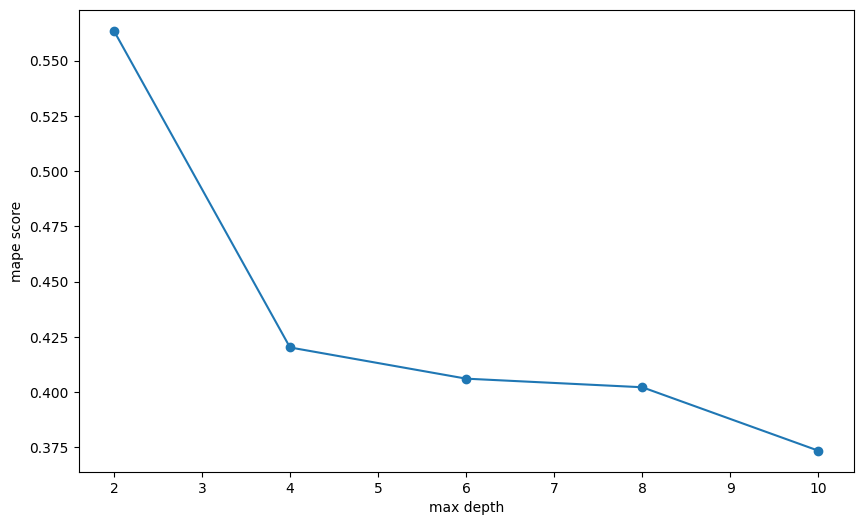

In [144]:
max_depth=[2,4,6,8,10]
mape_scores=[]


for depth in max_depth:
    model_xgb=XGBRegressor(learning_rate=0.5,n_estimators=1000,max_depth=depth)
    pipeline_xgb=Pipeline([('step1',encoder),('step2',normalization),('step3',model_xgb)])

    pipeline_xgb.fit(X_train, y_train)
    val_pred_xgb = pipeline_xgb.predict(X_val)

    # Calculate R2 score and mean absolute error
    mape_scores.append(mean_absolute_percentage_error(y_val,val_pred_xgb))
plt.figure(figsize=(10,6))
plt.plot(max_depth,mape_scores,marker='o')
plt.xlabel('max depth')
plt.ylabel('mape score')
plt.show()

chọn max_depth=10

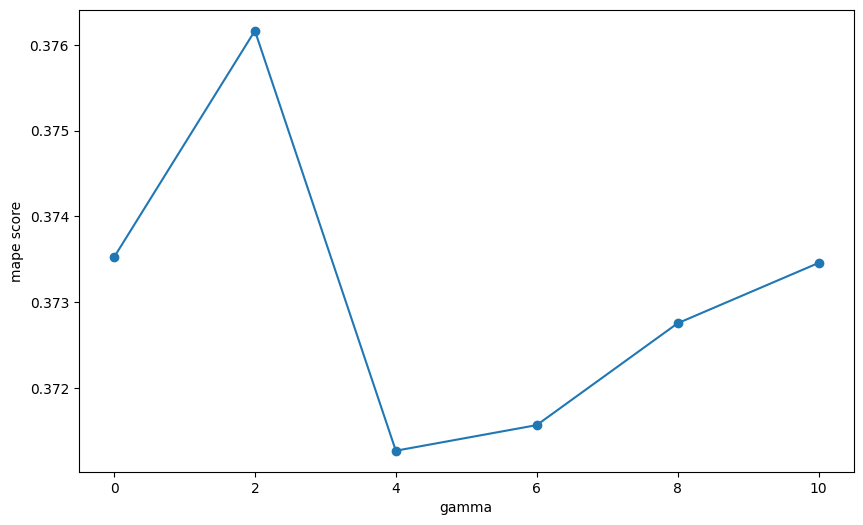

In [145]:
gamma=[0,2,4,6,8,10]
mape_scores=[]


for g in gamma:
    model_xgb=XGBRegressor(learning_rate=0.5,n_estimators=1000,max_depth=10,gamma=g)
    pipeline_xgb=Pipeline([('step1',encoder),('step2',normalization),('step3',model_xgb)])

    pipeline_xgb.fit(X_train, y_train)
    val_pred_xgb = pipeline_xgb.predict(X_val)

    # Calculate R2 score and mean absolute error
    mape_scores.append(mean_absolute_percentage_error(y_val,val_pred_xgb))
plt.figure(figsize=(10,6))
plt.plot(gamma,mape_scores,marker='o')
plt.xlabel('gamma')
plt.ylabel('mape score')
plt.show()

In [146]:
best_model_xgb=XGBRegressor(learning_rate=0.5,n_estimators=1000,max_depth=10,gamma=4)
pipeline_xgb=Pipeline([('step1',encoder),('step2',normalization),('step3',best_model_xgb)])
pipeline_xgb.fit(X_train,y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal encoding',
                                                  JamesSteinEncoder(), [1]),
                                                 ('nominal encoding',
                                                  OneHotEncoder(sparse_output=False),
                                                  [0, 3, 4, 5, 6])])),
                ('step2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('normalization',
                                                  StandardScaler(),
                                                  [1, 2, 7, 8])])),
                ('step3',
                 XGBRegressor(base_score=None, boos...
                              feature_types=None, gamma=4, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.5,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [147]:
test_pred_xgb=pipeline_xgb.predict(X_test)
mape_xgb=mean_absolute_percentage_error(y_test,test_pred_xgb)

In [148]:
mape_xgb

0.37595349029068564

#### Stacking Regressor

In [149]:
base_regressors = [('rf', best_model_rf), ('knn',best_model_knn ), ('xgb', best_model_xgb)]
model_stacking=StackingRegressor(estimators=base_regressors, final_estimator=LinearRegression())
pipeline_stacking=Pipeline([('step1',encoder),('step2',normalization),('step3',model_stacking)])

In [150]:
pipeline_stacking.fit(X_train,y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal encoding',
                                                  JamesSteinEncoder(), [1]),
                                                 ('nominal encoding',
                                                  OneHotEncoder(sparse_output=False),
                                                  [0, 3, 4, 5, 6])])),
                ('step2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('normalization',
                                                  StandardScaler(),
                                                  [1, 2, 7, 8])])),
                ('step3',
                 StackingRegressor(estimators=[('r...
                                                             interaction_constraints=None,
                                                             learning_rate=0.5,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=10,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=1000,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))],
                                   final_estimator=LinearRegression()))])

In [151]:
test_pred_stacking=pipeline_stacking.predict(X_test)
mape_stacking=mean_absolute_percentage_error(y_test,test_pred_stacking)

In [152]:
mape_stacking

0.3025094759655519

#### MLP

In [153]:
model_mlp=MLPRegressor(hidden_layer_sizes=(32,64,16))
pipeline_mlp=Pipeline([('step1',encoder),('step2',normalization),('step3',model_mlp)])

In [154]:
para_grid_mlp_tune={'step3__learning_rate_init':[0.001,0.005,0.01,0.05,0.1],
                   'step3__learning_rate':['constant','invscaling','adaptive'],
                   'step3__batch_size':[32,64,128,'auto']}

In [155]:
grid_search_mlp= GridSearchCV(pipeline_mlp,para_grid_mlp_tune, cv=5, scoring='neg_mean_absolute_percentage_error')
grid_search_mlp.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('step1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal '
                                                                         'encoding',
                                                                         JamesSteinEncoder(),
                                                                         [1]),
                                                                        ('nominal '
                                                                         'encoding',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         [0, 3,
                                                                          4, 5,
                                                                          6])])),
                                       ('step2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('normalization',
                                                                         StandardScaler(),
                                                                         [1, 2,
                                                                          7,
                                                                          8])])),
                                       ('step3',
                                        MLPRegressor(hidden_layer_sizes=(32, 64,
                                                                         16)))]),
             param_grid={'step3__batch_size': [32, 64, 128, 'auto'],
                         'step3__learning_rate': ['constant', 'invscaling',
                                                  'adaptive'],
                         'step3__learning_rate_init': [0.001, 0.005, 0.01, 0.05,
                                                       0.1]},
             scoring='neg_mean_absolute_percentage_error')

In [156]:
best_params_mlp = grid_search_mlp.best_params_
print(f'best hyper parameters set is : {best_params_mlp}')

best hyper parameters set is : {'step3__batch_size': 'auto', 'step3__learning_rate': 'adaptive', 'step3__learning_rate_init': 0.001}


In [157]:
test_pred_mlp=grid_search_mlp.best_estimator_.predict(X_test)
mape_mlp=mean_absolute_percentage_error(y_test,test_pred_mlp)

In [158]:
mape_mlp

0.6684686244718883

## Evaluation

In [159]:
y_test_cop=y_test.to_numpy().reshape(-1,1)
def accuracy_price(x):
  x=x.reshape(-1,1)
  return len(np.where(((abs(y_test_cop-x))/y_test_cop)<0.12)[0])/len(y_test_cop)

In [160]:
test_pred=[test_pred_ridge,test_pred_rf,test_pred_knn,test_pred_xgb,test_pred_stacking,test_pred_xgb]
model=['Ridge','Random Forest','KNN','XGBoost','Stacking Regression','MLP']
test_accuracy=[]
for i in test_pred:
  test_accuracy.append(accuracy_price(i))
mape_scores=[mape_ridge,mape_rf,mape_knn,mape_xgb,mape_stacking,mape_mlp]

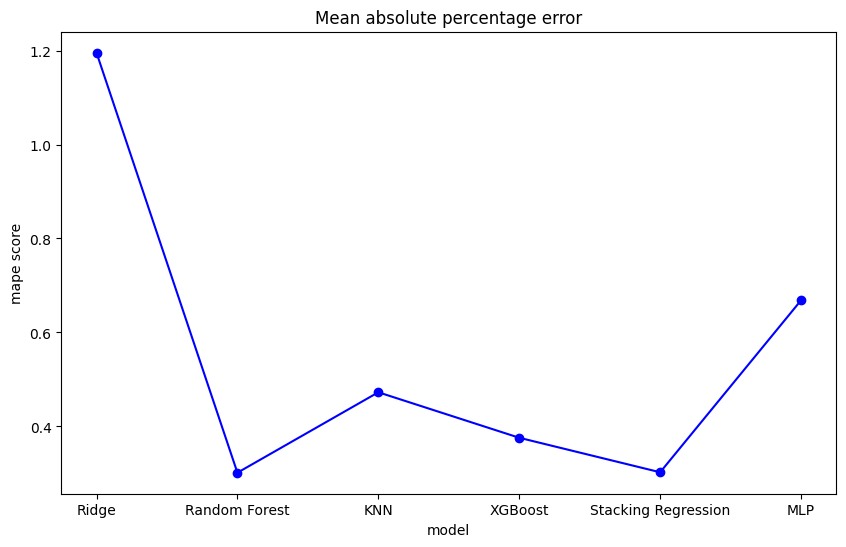

In [161]:
plt.figure(figsize=(10,6))
plt.plot(model,mape_scores,color='b',marker='o')
plt.xlabel('model')
plt.ylabel('mape score')
plt.title('Mean absolute percentage error')
plt.show()

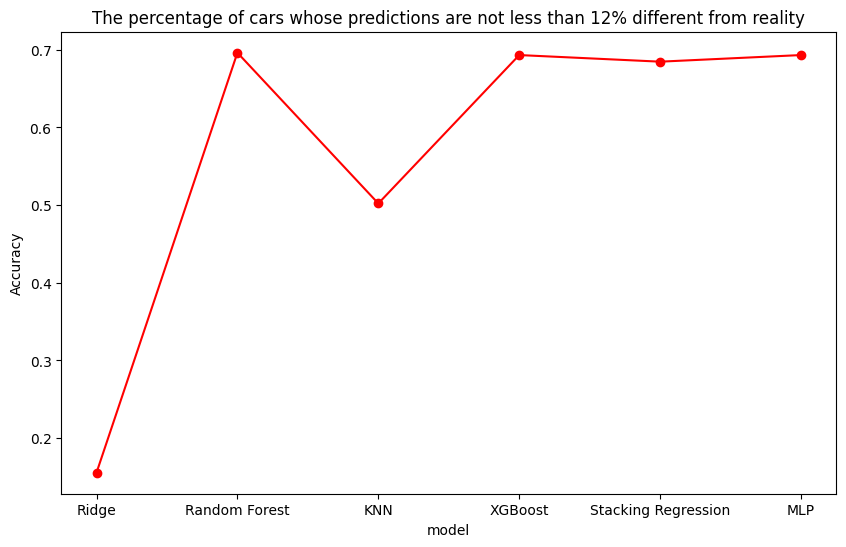

In [162]:
plt.figure(figsize=(10,6))
plt.plot(model,test_accuracy,color='r',marker='o')
plt.xlabel('model')
plt.ylabel('Accuracy')
plt.title('The percentage of cars whose predictions are not less than 12% different from reality')
plt.show()

# Save model

In [163]:
import pickle

In [164]:
pickle.dump(pipeline_stacking,open('model_stacking.pkl', 'wb'))